In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Introduction
This is an introduction to your report, you should edit this text/mardown section to compose. In this text/markdown, you should introduce:


*   **Background of the problem**
  * **what type of problem: disease/readmission/mortality prediction,  feature engineeing, data processing, etc**

      The main problem this research aims to solve is to predict the chance of ICU patients contracting Sepsis, having a Myocardial infarction (heart attack), or the administration of Vancomycin. These are all clinical endpoints for ICU patients and providing a model that accurately predict these targets can alleviate the continually increasing pressures on ICU physcians.

  * **what is the importance/meaning of solving the problem**
      
      Solving this problem provides two main benefits. Firstly it provides ICU physicans with a model that is interpretable and accurate in its predictions on these targets. This will be useful to physicians by reducing information overload and by "providing needed clinical decision support for a variety of clinically important tasks".

  * **what is the difficulty of the problem**

      The problem is difficult for a few key reasons. Firstly, there have been attempts to create models based on linear/hazard regression to predict these cases, but these models have failed to learn non-linear relationships in medicine and biology. More importantly, these models are not very interpretable to physicians, so they become difficult to use. In order to combat this, we will train an LSTM model with attention mechanisms to provide greater interperetability and accuracy.

  * **the state of the art methods and effectiveness**

      For this problem, an RNN model by itself is not enough to achieve interpretability. To mitigate this, LSTMs with attention mechanisms are used to improve effectiveness. This method is taken from the soft attention model, RETAIN from Choi et al.,  which was able to predict outpatient heart failure and "used attention at the level of two parallel RNNs to interpret visit- and variable-level importance".

* **Paper explanation**
  * **what did the paper propose**

      In the paper “An attention based deep learning model of clinical events in the intensive care unit” Kaji and other researchers trained LSTM RNNs incorporating an attention mechanism in order to predict: Daily sepsis the body reacts adversely when responding to an infection, Myocardial infarction (MI): blood flow to the heart is restricted, also called heart attack, Vancomycin antibiotic administration (VAA): a drug intended to kill bacteria in the intestines to fight colitis.

  * **what is the innovations of the method**

      The method is innovative with regards to its use of soft attention in combination with LSTMs to predict these specific targets.
      
  * **how well the proposed method work (in its own metrics)**

      Per the result metrics, these models achieved next-day predictive AUC of 0.876 for sepsis, 0.823 for MI, and 0.833 for vancomycin administration.

  * **what is the contribution to the reasearch regime (referring the Background above, how important the paper is to the problem).**

      The results of these models further prove the soft attention and RNN methods for predicting clinically important tasks. This paper proved that "Machine learning models could be of great value in providing timely decision support to ICU clinicians, distilling the information overload that is typical of the environment down into the most relevant factors for that patient in any given moment". These types of models can help in identifying "potentially non-intuitive and important predictive variables from a wide variety of inputs".

* **Code Link**
    * https://github.com/archu-s/mimic-lstm/tree/updated


# Scope of Reproducibility:

List hypotheses from the paper you will test and the corresponding experiments you will run.

The paper hypothesizes that it would be possible to predict a variety of clinical endpoints in the ICU by training a Recurrent Neural Network (RNN) to routinely available variables from a critically ill patient’s ICU admission to sequences of those endpoints, and that the incorporation of variable-level attention could promote straightforward interpretability of such a model to clinicians.


1.   Hypothesis 1: The paper hypothesizes that it would be possible to predict contraction of Sepsis in ICU patients using the patient's ICU admission information while maintaining interpretability

2.   Hypothesis 2: The paper hypothesizes that it would be possible to predict the onset of Myocardial infarctions in ICU patients using the patient's ICU admission information while maintaining interpretability

3.  Hypothesis 3: The paper hypothesizes that it would be possible to predict the administration of Vancomycin in ICU patients using the patient's ICU admission information while maintaining interpretability



# Methodology


In [ ]:
# import  packages you need
import numpy as np
from google.colab import drive

##  Data
Data includes raw data (MIMIC III tables), descriptive statistics (our homework questions), and data processing (feature engineering).

**Source of the data: where the data is collected from; if data is synthetic or self-generated, explain how. If possible, please provide a link to the raw datasets.**

  The data for this researched is sourced from the MIMIC-III database which is a relational database composed of 26 tables. Each of these tables represents a healthcare-related entity. Each table has an ID key that acts as the primary key, for example each procedure would have an procedure_id. These keys can be joined accross tables to providing meaningful views to users.

  Certain tables contain event data which includes data such as lab tests and notes. Some tables act as dictionary tables and are prefixed with the D_ identifier and need to be joined with other data to provide meaningful views.

  Some Broader Categories of tables:

  - Patient Stays: ADMISSIONS; PATIENTS; ICUSTAYS; SERVICES; and TRANSFERS

  - Dictionaries: D_CPT; D_ICD_DIAGNOSES; D_ICD_PROCEDURES; D_ITEMS; and D_LABITEMS


  Data can be downloaded here assuming as long as the user has been approved to access the database: https://physionet.org/content/mimiciii/1.4/

  The data from this database is exported to csv format and downloaded to be fed as input into to MIMIC processor file. Below is a preview of data before any processing beyond an inital filter of only relevant features.



In [ ]:
# load CSV raw example
import pandas as pd

ROOT = "/content/drive/MyDrive/Colab Notebooks/"
FILE = "mimic_database/mapped_elements/CHARTEVENTS_reduced_day_features_24_hour_blocks.csv"

chart_events_reduced = pd.read_csv(ROOT + FILE)

Sample of data from the CHARTEVENTS Table (Projected to show only relevant features)

In [ ]:
chart_events_reduced.head()

,BUN,HDL,INR,Inspired O2 Fraction,LDL,PEEP Set,PTT,RBCs,WBCs,anion gap,...,potassium_max,pulse oximetry_max,respiratory rate_max,sodium_max,systolic_max,temperature (F)_max,tidal volume_max,triglycerides_max,troponin_max,HADMID_DAY
0,41.000000,41.0,15.3,50.0,81.0,5.0,32.4,3.39,11.2,18.000000,...,4.2,100.0,22.0,143.0,138.0,100.0,500.0,117.0,0.07,100001_2117-09-11
1,31.333333,41.0,15.3,50.0,81.0,5.0,32.4,3.39,10.4,14.666667,...,4.1,99.0,26.0,145.0,138.0,99.9,500.0,117.0,0.07,100001_2117-09-12
2,21.500000,41.0,15.3,50.0,81.0,5.0,32.4,3.39,15.9,14.000000,...,4.4,99.0,20.0,142.0,138.0,99.9,500.0,117.0,0.07,100001_2117-09-13
3,17.000000,41.0,15.3,50.0,81.0,5.0,32.4,3.39,10.5,14.500000,...,4.2,99.0,26.0,138.0,138.0,99.6,500.0,117.0,0.07,100001_2117-09-14
4,17.000000,41.0,15.3,50.0,81.0,5.0,32.4,3.39,6.1,15.000000,...,3.5,98.0,26.0,138.0,138.0,99.6,500.0,117.0,0.07,100001_2117-09-15


In [ ]:
chart_events_reduced.describe()

,BUN,HDL,INR,Inspired O2 Fraction,LDL,PEEP Set,PTT,RBCs,WBCs,anion gap,...,polymorphonuclear leukocytes_max,potassium_max,pulse oximetry_max,respiratory rate_max,sodium_max,systolic_max,temperature (F)_max,tidal volume_max,triglycerides_max,troponin_max
count,346317.000000,346317.000000,346317.000000,346317.000000,346317.000000,346317.000000,346317.000000,346317.000000,346317.000000,346317.000000,...,346317.000000,346317.000000,346317.000000,346317.000000,346317.000000,346317.000000,346317.000000,346317.000000,346317.000000,346317.000000
mean,25.538646,40.996822,15.470064,49.825879,80.997035,5.357620,34.105307,3.387893,11.023962,13.023946,...,81.774058,4.177794,99.748667,26.367475,138.923424,129.675670,99.134444,504.386401,117.346284,0.091111
std,14.266138,0.924544,1.303531,4.847425,1.974255,1.286709,8.868606,0.319557,3.701620,1.711822,...,3.553614,0.425688,1.099121,4.856979,3.486165,33.343568,1.658693,50.678536,11.764615,0.248364
min,0.000000,2.000000,7.900000,0.000000,1.000000,0.000000,0.000000,0.000000,0.050000,-7.000000,...,0.000000,1.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,17.666667,41.000000,15.300000,50.000000,81.000000,5.000000,32.400000,3.390000,9.200000,13.000000,...,82.000000,4.000000,100.000000,24.000000,138.000000,115.000000,98.600000,500.000000,117.000000,0.070000
50%,23.000000,41.000000,15.300000,50.000000,81.000000,5.000000,32.400000,3.390000,10.900000,13.000000,...,82.000000,4.200000,100.000000,26.000000,139.000000,138.000000,99.199997,500.000000,117.000000,0.070000
75%,27.000000,41.000000,15.300000,50.000000,81.000000,5.000000,32.400000,3.390000,12.050000,13.000000,...,82.000000,4.300000,100.000000,28.000000,140.000000,152.000000,99.599998,500.000000,117.000000,0.070000
max,82.000000,71.000000,25.400000,86.666667,154.000000,12.450000,81.966667,4.620000,23.400000,20.000000,...,94.100000,5.500000,100.000000,40.000000,147.000000,188.000000,101.900002,700.000000,412.000000,6.300000





**Data process: how do you munipulate the data, e.g., change the class labels, split the dataset to train/valid/test, refining the dataset**


  After downloading the source data from MIMIC-III, the data is passed into the mimic_processor function where it is processed for input into the model.

  First an instantiated object of the ParseItemID class is created. This class contains the set of features, feature names and patterns that will be extracted from the data. For example, these feature names are instantiated with a ParseItemID object to be extracted.

  ```
          self.feature_names = ['RBCs', 'WBCs', 'platelets', 'hemoglobin', 'hemocrit',
                                'atypical lymphocytes', 'bands', 'basophils', 'eosinophils', 'neutrophils',
                                'lymphocytes', 'monocytes', 'polymorphonuclear leukocytes',
                                'temperature (F)', 'heart rate', 'respiratory rate', 'systolic', 'diastolic',
                                'pulse oximetry',
                                'troponin', 'HDL', 'LDL', 'BUN', 'INR', 'PTT', 'PT', 'triglycerides', 'creatinine',
                                'glucose', 'sodium', 'potassium', 'chloride', 'bicarbonate',
                                'blood culture', 'urine culture', 'surface culture', 'sputum' +
                                ' culture', 'wound culture', 'Inspired O2 Fraction', 'central venous pressure',
                                'PEEP Set', 'tidal volume', 'anion gap',
                                'daily weight', 'tobacco', 'diabetes', 'history of CV events']
  ```

  The main purpose of this object is transform the data from the MIMIC-III database to pandas dataframes projected with the relevant columns to be used in the operation.

  This is done by

  1. Filtering out events from CHARTEVENTS that are not feature relevant
  2. Taking daily shards of the data and build them out
  3. Adding columns related to the demographics of admits
  4. Adding columns related to the prescriptions for patients
  5. Adding columns related to the procedures and infections for patients
  6. Adding columns related to the notes for the patients, specifically:
      - Radiology notes
      - CT aniograms notes
      - Chest aniograms notes


  Once this data is created one final csv file with the suffix: `CHARTEVENTS_reduced_24_hour_blocks_plus_admissions_plus_patients_plus_scripts_plus_icds_plus_notes.csv` should be created. This file will have the complete set of transformed data from MIMIC-III

  At this point data will be fed to the RNN mimic's `return_data()` function to be split into train and test sets. Below is the final result CSV and some descriptive stats



In [ ]:
# load transformed data - shows stats about size and shape
import pandas as pd

ROOT = "/content/drive/MyDrive/Colab Notebooks/"
FILE = "mimic_database/mapped_elements/CHARTEVENTS_reduced_day_features_24_hour_blocks_plus_admissions_plus_patients_plus_scripts_plus_icds_plus_notes.csv"

df = pd.read_csv(ROOT + FILE)

**Statistics: include basic descriptive statistics of the dataset like size, cross validation split, label distribution, etc**



In [ ]:
df.describe()

,BUN,HDL,INR,Inspired O2 Fraction,LDL,PEEP Set,PTT,RBCs,WBCs,anion gap,...,tacrolimus,trazodone,vancomycin,vasopressin,warfarin,zolpidem,HADM_ID,CKD,Infection,ct_angio
count,628391.000000,628391.000000,628391.000000,628391.000000,628391.000000,628391.000000,628391.000000,628391.000000,628391.000000,628391.000000,...,628391.000000,628391.000000,628391.000000,628391.000000,628391.00000,628391.000000,628391.000000,628391.000000,628391.000000,628391.000000
mean,14.074783,22.594048,8.525816,27.459892,44.638848,2.952676,18.796017,1.867126,6.075494,7.177719,...,0.020077,0.051221,0.243170,0.016353,0.08510,0.061107,150354.076193,0.000054,0.919859,0.722728
std,16.538329,20.402571,7.755123,25.042333,40.313004,2.830807,18.196171,1.701689,6.133174,6.601333,...,0.140263,0.220449,0.428997,0.126829,0.27903,0.239526,28976.136663,0.007356,0.271512,0.447652
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-7.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,100001.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,125385.000000,0.000000,1.000000,0.000000
50%,11.000000,41.000000,14.600000,50.000000,81.000000,5.000000,26.900000,3.000000,6.400000,11.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,150661.000000,0.000000,1.000000,1.000000
75%,23.000000,41.000000,15.300000,50.000000,81.000000,5.000000,32.400000,3.390000,10.900000,13.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,175426.000000,0.000000,1.000000,1.000000
max,82.000000,71.000000,25.400000,86.666667,154.000000,12.450000,81.966667,4.620000,23.400000,20.000000,...,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,199999.000000,1.000000,1.000000,1.000000


In [ ]:
df.head()

,BUN,HDL,INR,Inspired O2 Fraction,LDL,PEEP Set,PTT,RBCs,WBCs,anion gap,...,tacrolimus,trazodone,vancomycin,vasopressin,warfarin,zolpidem,HADM_ID,CKD,Infection,ct_angio
0,41.000000,41.0,15.3,50.0,81.0,5.0,32.4,3.39,11.2,18.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,100001,0,1,0
1,31.333333,41.0,15.3,50.0,81.0,5.0,32.4,3.39,10.4,14.666667,...,0.0,0.0,0.0,0.0,0.0,0.0,100001,0,1,0
2,21.500000,41.0,15.3,50.0,81.0,5.0,32.4,3.39,15.9,14.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,100001,0,1,0
3,17.000000,41.0,15.3,50.0,81.0,5.0,32.4,3.39,10.5,14.500000,...,0.0,0.0,0.0,0.0,0.0,0.0,100001,0,1,0
4,17.000000,41.0,15.3,50.0,81.0,5.0,32.4,3.39,6.1,15.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,100001,0,1,0


In [ ]:
df.shape

(628391, 235)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 628391 entries, 0 to 628390
Columns: 235 entries, BUN to ct_angio
dtypes: float64(227), int64(4), object(4)
memory usage: 1.1+ GB


**Illustration: printing results, plotting figures for illustration**

Overview of Data Flow:

  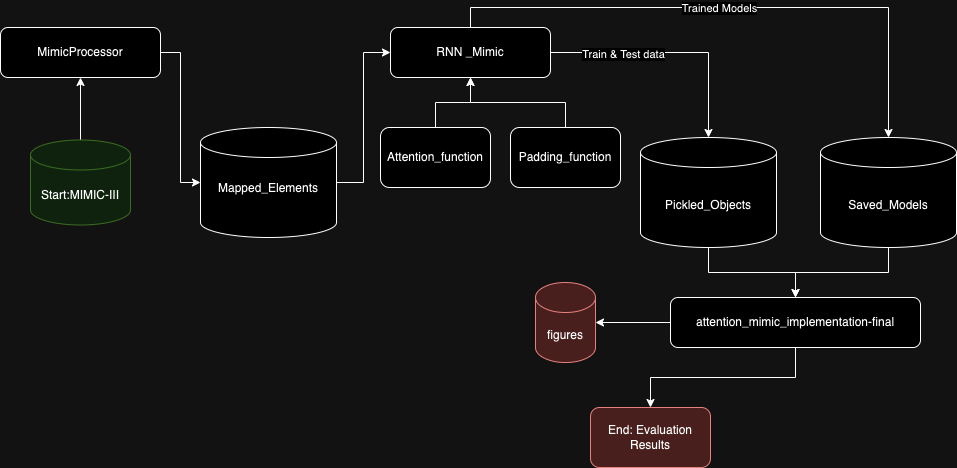

<Axes: xlabel='vancomycin'>

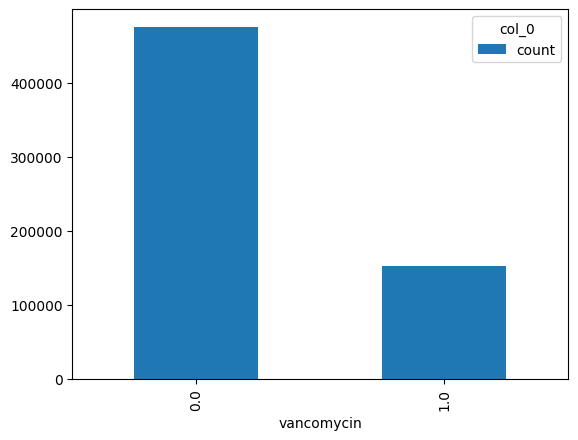

In [ ]:
van_table = pd.crosstab(index=df["vancomycin"],  columns="count")
van_table.plot(kind="bar")

**Setting up environment to run**

The file structure should be like this:

- Green - Needs to be created/uploaded by the user
- Red - RNN mimic, padding, and attention need to be created by the user, the rest will be auto generated
- Blue - Proccessor needs to be created by the user, the rest will be auto generated
- Purple - The main file needs to be run by the user, and the rest will be auto generated

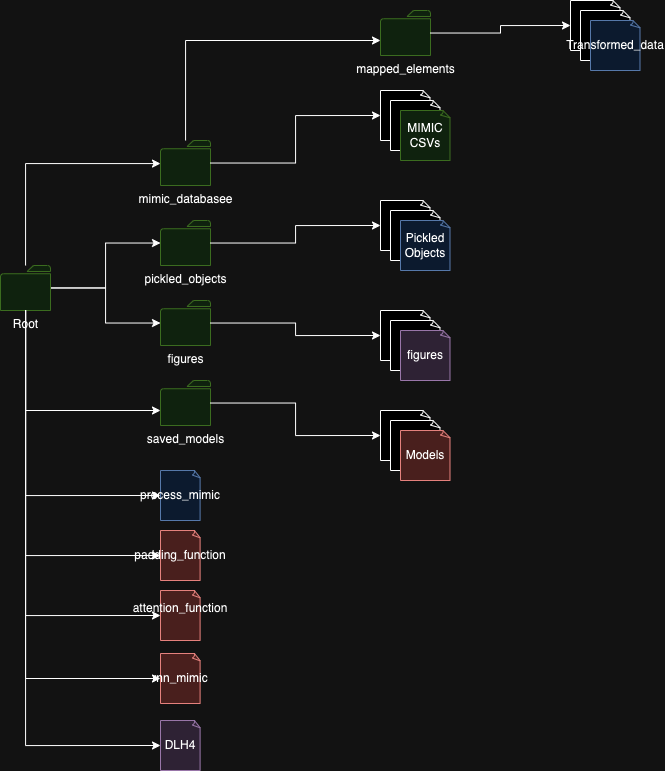

##   Model
The model includes the model definitation located in the rnn_mimic.py file. This model is used to handle and predict Myocardial Infarction (MI), Sepsis, and Vancomycin administration from the MIMIC-III dataset.

**Model architecture:**
1. Input Later: Receives the time series data (Shape determined by the time_steps and the no_feature_cols)
2. Attention Layer: Applies the attention mechanism
3. Masking Layer: Used to ignore cetrain timesteps to pad with zeros
4. LSTM Layer: Process the time serives data (256 units to return sequences)
5. Output Layer: Applies a sigmoid activiation function

**Training Objectives:**

1.   Loss Function: The model uses binary cross-entropy
2.   Optimizer: RMSprop with specific hyperparameters (lr=0.001, rho=0.9, epsilon=1e-08)
3. Weight of each loss term: Binary cross-entropy loss accross all output predictions

**Others:**
Model is not pretrained, and there is no Monte Carlo Simulation.

##   Training


**Computational requirements:**

1.   rnn_mimic.py file has the code to generate pickel files from the raw preprocessed file CHARTEVENTS_reduced_day_features_24_hour_blocks_plus_admissions_plus_patients_plus_scripts_plus_icds_plus_notes.csv. And used load pickle files to build and train model.
2. Preprocessed data file CHARTEVENTS_reduced_day_features_24_hour_blocks_plus_admissions_plus_patients_plus_scripts_plus_icds_plus_notes.csv has 6,28,391 rows.
3. We have tried building pickle files and training model on Google Colab T4 GPU, however it was still taking very long time and after that it was timing out.
4. Hence we only read first 50,000 rows from the CHARTEVENTS_reduced_day_features_24_hour_blocks_plus_admissions_plus_patients_plus_scripts_plus_icds_plus_notes.csv and generate pickle files on google Colab CPU.
5. And model are build and trained on generated pickel files with reduced epoches = 5.

Load RNN for training and evaluation

In [ ]:
import sys

# Append the directory to your python path using sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/')

# Import the module
import rnn_mimic

Load Relevant Pakcages

In [ ]:
import gc
import numpy as np
import pandas as pd
import tensorflow as tf
import keras.backend as K
from rnn_mimic import return_loaded_model
from seaborn import heatmap
import seaborn as sns
import pickle
from sklearn.metrics import roc_curve, accuracy_score, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import kurtosis

# plot part.
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

In [ ]:
# !python '/content/drive/MyDrive/Colab Notebooks/attention_function.py'

2024-04-13 20:33:20.915415: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-13 20:33:20.915498: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-13 20:33:20.918232: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-13 20:33:23.866558: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


The following parameters are used to split the data:

       synth_data : synthetic data is False by default
       balance : whether or not to balance positive and negative time windows
       target : desired target, supports MI, SEPSIS, VANCOMYCIN or a known lab, medication
       return_cols : return columns used for this RNN
       tt_split : fraction of dataset to use fro training, remaining is used for test
       cross_val : parameter that returns entire matrix unsplit and unbalanced for cross val purposes
       mask : 24 hour mask, default is False
       dataframe : returns dataframe rather than numpy ndarray
       time_steps : 14 by default, required for padding
       split : creates test train splits
       pad : by default is True, will pad to the time_step value

```
def return_data(synth_data=False, balancer=True, target='MI',
                 return_cols=False, tt_split=0.7, val_percentage=0.8,
                 cross_val=False, mask=False, dataframe=False,
                 time_steps=14, split=True, pad=True):
```

Training From Scratch:

In [ ]:
## This python file is responsbile for loading the raw preprocessed data file mimic_database/mapped_elements/CHARTEVENTS_reduced_day_features_24_hour_blocks_plus_admissions_plus_patients_plus_scripts_plus_icds_plus_notes.csv
## and build and train the model. The model summary is shown in the output, along with the shape of the raw preprocessed input file.
## Please note for compuational purpose we are only reading first 50000 rows, and reading full file and training on them was timing out even when we tried on Google Colab with T4 GPU.
## The model is build and train on Google Colab CPU runtime.

!python '/content/drive/MyDrive/Colab Notebooks/rnn_mimic.py'

2024-04-13 18:15:42.684735: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-13 18:15:42.684784: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-13 18:15:42.686158: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-13 18:15:43.954033: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Creating pickled_object file for traget MI
Dataframe Shape from the file /content/drive/MyDrive/Colab Notebooks/mimic_database/mapped_elements/CHARTEVENTS_reduced_day_features_24_hour_blocks_plus_admissions_plus_patients_plus_scripts_plus_ic

Set Target for training from Picklefile (Note: there are 3 targets to manually set MI, SEPSIS, VANCOMYCIN)

*For the purposes of this draft, we ran on just VANCOMYCIN*

In [ ]:
target = 'VANCOMYCIN'

In [ ]:
## PICKLE LOADS
ROOT = "/content/drive/MyDrive/Colab Notebooks/"

X_TRAIN_MI = pickle.load(open(ROOT+'pickled_objects/X_TRAIN_MI.txt', 'rb'))
X_TRAIN_SEPSIS = pickle.load(open(ROOT+'pickled_objects/X_TRAIN_SEPSIS.txt', 'rb'))
X_TRAIN_VANCOMYCIN = pickle.load(open(ROOT+'pickled_objects/X_TRAIN_VANCOMYCIN.txt', 'rb'))

Y_TRAIN_MI = pickle.load(open(ROOT+'pickled_objects/Y_TRAIN_MI.txt', 'rb'))
Y_TRAIN_SEPSIS = pickle.load(open(ROOT+'pickled_objects/Y_TRAIN_SEPSIS.txt', 'rb'))
Y_TRAIN_VANCOMYCIN = pickle.load(open(ROOT+'pickled_objects/Y_TRAIN_VANCOMYCIN.txt', 'rb'))

Y_VAL_MI = pickle.load(open(ROOT+'pickled_objects/Y_VAL_MI.txt', 'rb'))
Y_VAL_SEPSIS = pickle.load(open(ROOT+'pickled_objects/Y_VAL_SEPSIS.txt', 'rb'))
Y_VAL_VANCOMYCIN = pickle.load(open(ROOT+'pickled_objects/Y_VAL_VANCOMYCIN.txt', 'rb'))

X_VAL_MI = pickle.load(open(ROOT+'pickled_objects/X_VAL_MI.txt', 'rb'))
X_VAL_SEPSIS = pickle.load(open(ROOT+'pickled_objects/X_VAL_SEPSIS.txt', 'rb'))
X_VAL_VANCOMYCIN = pickle.load(open(ROOT+'pickled_objects/X_VAL_VANCOMYCIN.txt', 'rb'))

Y_TEST_MI = pickle.load(open(ROOT+'pickled_objects/Y_TEST_MI.txt', 'rb'))
Y_TEST_SEPSIS = pickle.load(open(ROOT+'pickled_objects/Y_TEST_SEPSIS.txt', 'rb'))
Y_TEST_VANCOMYCIN = pickle.load(open(ROOT+'pickled_objects/Y_TEST_VANCOMYCIN.txt', 'rb'))

X_TEST_MI = pickle.load(open(ROOT+'pickled_objects/X_TEST_MI.txt', 'rb'))
X_TEST_SEPSIS = pickle.load(open(ROOT+'pickled_objects/X_TEST_SEPSIS.txt', 'rb'))
X_TEST_VANCOMYCIN = pickle.load(open(ROOT+'pickled_objects/X_TEST_VANCOMYCIN.txt', 'rb'))

y_boolmat_test_MI = pickle.load(open(ROOT+'pickled_objects/y_boolmat_test_MI.txt', 'rb'))
y_boolmat_test_SEPSIS = pickle.load(open(ROOT+'pickled_objects/y_boolmat_test_SEPSIS.txt', 'rb'))
y_boolmat_test_VANCOMYCIN = pickle.load(open(ROOT+'pickled_objects/y_boolmat_test_VANCOMYCIN.txt', 'rb'))

x_boolmat_test_MI = pickle.load(open(ROOT+'pickled_objects/x_boolmat_test_MI.txt', 'rb'))
x_boolmat_test_SEPSIS = pickle.load(open(ROOT+'pickled_objects/x_boolmat_test_SEPSIS.txt', 'rb'))
x_boolmat_test_VANCOMYCIN = pickle.load(open(ROOT+'pickled_objects/x_boolmat_test_VANCOMYCIN.txt', 'rb'))

no_features_cols_MI = pickle.load(open(ROOT+'pickled_objects/no_feature_cols_MI.txt', 'rb'))
no_features_cols_SEPSIS = pickle.load(open(ROOT+'pickled_objects/no_feature_cols_SEPSIS.txt', 'rb'))
no_features_cols_VANCOMYCIN = pickle.load(open(ROOT+'pickled_objects/no_feature_cols_VANCOMYCIN.txt', 'rb'))

features_MI = pickle.load(open(ROOT+'pickled_objects/features_MI.txt', 'rb'))
features_SEPSIS = pickle.load(open(ROOT+'pickled_objects/features_SEPSIS.txt', 'rb'))
features_VANCOMYCIN = pickle.load(open(ROOT+'pickled_objects/features_VANCOMYCIN.txt', 'rb'))

if target == 'MI':
    my_cmap = ListedColormap(sns.color_palette("Reds", 150))
    color_list = sns.color_palette("Reds", 14)
    color_list_reduced = sns.color_palette("Reds", 7)
    X_TRAIN = X_TRAIN_MI
    X_VAL = X_VAL_MI
    Y_TRAIN = Y_TRAIN_MI
    Y_VAL = Y_VAL_MI
    Y_TEST = Y_TEST_MI
    X_TEST = X_TEST_MI
    y_boolmat_test = y_boolmat_test_MI
    x_boolmat_test = x_boolmat_test_MI
    features = features_MI

elif target == 'SEPSIS':
    my_cmap = sns.cubehelix_palette(14, start=2, rot=0, dark=0.25, light=.95, as_cmap=True)
    color_list = sns.cubehelix_palette(14, start=2, rot=0, dark=0.15, light=.8)
    color_list_reduced = sns.cubehelix_palette(7, start=2, rot=0, dark=0.15, light=.8)
    X_TRAIN = X_TRAIN_SEPSIS
    X_VAL = X_VAL_SEPSIS
    Y_TRAIN = Y_TRAIN_SEPSIS
    Y_VAL = Y_VAL_SEPSIS
    Y_TEST = Y_TEST_SEPSIS
    X_TEST = X_TEST_SEPSIS
    y_boolmat_test = y_boolmat_test_SEPSIS
    x_boolmat_test = x_boolmat_test_SEPSIS
    features = features_SEPSIS

elif target == 'VANCOMYCIN':
    my_cmap= sns.cubehelix_palette(14, as_cmap=True)
    color_list = sns.cubehelix_palette(14)
    color_list_reduced = sns.cubehelix_palette(7)
    X_TRAIN = X_TRAIN_VANCOMYCIN
    X_VAL = X_VAL_VANCOMYCIN
    Y_TRAIN = Y_TRAIN_VANCOMYCIN
    Y_VAL = Y_VAL_VANCOMYCIN
    Y_TEST = Y_TEST_VANCOMYCIN
    X_TEST = X_TEST_VANCOMYCIN
    y_boolmat_test = y_boolmat_test_VANCOMYCIN
    x_boolmat_test = x_boolmat_test_VANCOMYCIN
    features = features_VANCOMYCIN

# Y_TRAIN[Y_TRAIN == -1] = np.nan
# Y_VAL[Y_VAL == -1] = np.nan
# Y_TEST[Y_TEST == -1] = np.nan
Y_TOTAL = np.concatenate([Y_TRAIN, Y_VAL, Y_TEST], axis=0)

In [ ]:
Y_MI = np.concatenate([Y_TRAIN_MI, Y_VAL_MI], axis=0)
Y_SEPSIS = np.concatenate([Y_TRAIN_SEPSIS, Y_VAL_SEPSIS], axis=0)
Y_VANCOMYCIN = np.concatenate([Y_TRAIN_VANCOMYCIN, Y_VAL_VANCOMYCIN], axis=0)

In [ ]:
''' this function is adapted from Keras documentation '''

def get_activations(model, inputs, print_shape_only=False, layer_name=None, verbose=False):

    """
    Get activations from a model
    Args:
        model: a keras model
        inputs: the inputs for the model
        print_shape_only: whether to print the shape of the layer or the whole activation layer
        layer_name: name of specific layer to return
        verbose: whether to show all outputs
    Returns:
        activations: list, list of activations
    """
    activations = []
    inp = model.input
    if layer_name is None:
        outputs = [layer.output for layer in model.layers]
    else:
        outputs = [layer.output for layer in model.layers if layer.name == layer_name]  # all layer outputs
    funcs = [K.function([inp], [out]) for out in outputs]  # evaluation functions
    K.set_learning_phase(1)
    layer_outputs = [func([inputs])[0] for func in funcs]
    for layer_activations in layer_outputs:
        activations.append(layer_activations)
        if verbose:
            print('----- activations -----')
            if print_shape_only:
                print(layer_activations.shape)
            else:
                print(layer_activations)
    return activations

def normalize_activations(activations_matrix):
    means = np.nanmean(activations_matrix, axis=0)
    stds = np.nanstd(activations_matrix, axis=0)
    return (activations_matrix - means) / stds

In [ ]:
TIME_STEPS = X_VAL.shape[1] #number of time_steps

In [ ]:
if target == 'MI':
    m = return_loaded_model(model_name="kaji_mach_final_no_mask_MI_pad14")
    m_80 = return_loaded_model(model_name="kaji_mach_final_no_mask_MI_pad14_80_percent")
    m_60 = return_loaded_model(model_name="kaji_mach_final_no_mask_MI_pad14_60_percent")
    m_40 = return_loaded_model(model_name="kaji_mach_final_no_mask_MI_pad14_40_percent")
    m_20 = return_loaded_model(model_name="kaji_mach_final_no_mask_MI_pad14_20_percent")
    m_10 = return_loaded_model(model_name="kaji_mach_final_no_mask_MI_pad14_10_percent")
    m_5 = return_loaded_model(model_name="kaji_mach_final_no_mask_MI_pad14_5_percent")
   # m_bench = return_loaded_model(model_name="kaji_mach_final_no_mask_MI_pad14_bench")
elif target == 'SEPSIS':
    m = return_loaded_model(model_name="kaji_mach_final_no_mask_SEPSIS_pad14")
    m_80 = return_loaded_model(model_name="kaji_mach_final_no_mask_SEPSIS_pad14_80_percent")
    m_60 = return_loaded_model(model_name="kaji_mach_final_no_mask_SEPSIS_pad14_60_percent")
    m_40 = return_loaded_model(model_name="kaji_mach_final_no_mask_SEPSIS_pad14_40_percent")
    m_20 = return_loaded_model(model_name="kaji_mach_final_no_mask_SEPSIS_pad14_20_percent")
    m_10 = return_loaded_model(model_name="kaji_mach_final_no_mask_SEPSIS_pad14_10_percent")
    m_5 = return_loaded_model(model_name="kaji_mach_final_no_mask_SEPSIS_pad14_5_percent")
    #m_bench = return_loaded_model(model_name="kaji_mach_final_no_mask_SEPSIS_pad14_bench")
elif target == 'VANCOMYCIN':
    m = return_loaded_model(model_name="kaji_mach_final_no_mask_VANCOMYCIN_pad14")
    m_80 = return_loaded_model(model_name="kaji_mach_final_no_mask_VANCOMYCIN_pad14_80_percent")
    m_60 = return_loaded_model(model_name="kaji_mach_final_no_mask_VANCOMYCIN_pad14_60_percent")
    m_40 = return_loaded_model(model_name="kaji_mach_final_no_mask_VANCOMYCIN_pad14_40_percent")
    m_20 = return_loaded_model(model_name="kaji_mach_final_no_mask_VANCOMYCIN_pad14_20_percent")
    m_10 = return_loaded_model(model_name="kaji_mach_final_no_mask_VANCOMYCIN_pad14_10_percent")
    m_5 = return_loaded_model(model_name="kaji_mach_final_no_mask_VANCOMYCIN_pad14_5_percent")
    #m_bench = return_loaded_model(model_name="kaji_mach_final_no_mask_VANCOMYCIN_pad14_bench")

The total kurtosis is -1.2002623427048622 with 18.66268656716418 % of events occuring between days 0 and 2


<ipython-input-14-7af7364de9e5>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=y_vector_total, x=np.arange(14), palette=np.array(color_list)[color_rank])
<ipython-input-14-7af7364de9e5>:22: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(y=y_vector_total, x=np.arange(14), palette=np.array(color_list)[color_rank])
<ipython-input-14-7af7364de9e5>:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=y_vector_total_pos, x=np.arange(14), palette=np.array(color_list)[color_rank])
<ipython-input-14-7af7364de9e5>:39: UserWarning: Numpy array is not a supported type for `palette`. Please conv

The train kurtosis is -1.1869931806089977 with 18.61376021798365 % of events occuring between days 0 and 2


<ipython-input-14-7af7364de9e5>:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=y_vector_train, x=np.arange(14), palette=np.array(color_list)[color_rank])
<ipython-input-14-7af7364de9e5>:59: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(y=y_vector_train, x=np.arange(14), palette=np.array(color_list)[color_rank])
<ipython-input-14-7af7364de9e5>:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=y_vector_train_pos, x=np.arange(14), palette=np.array(color_list)[color_rank])
<ipython-input-14-7af7364de9e5>:77: UserWarning: Numpy array is not a supported type for `palette`. Please conv

The test kurtosis is -1.2725112468104065 with 18.71008939974457 % of events occuring between days 0 and 2


<ipython-input-14-7af7364de9e5>:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=y_vector_test, x=np.arange(14), palette=np.array(color_list)[color_rank])
<ipython-input-14-7af7364de9e5>:94: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(y=y_vector_test, x=np.arange(14), palette=np.array(color_list)[color_rank])
<ipython-input-14-7af7364de9e5>:111: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=y_vector_test_pos, x=np.arange(14), palette=np.array(color_list)[color_rank])
<ipython-input-14-7af7364de9e5>:111: UserWarning: Numpy array is not a supported type for `palette`. Please conve

<Figure size 640x480 with 0 Axes>

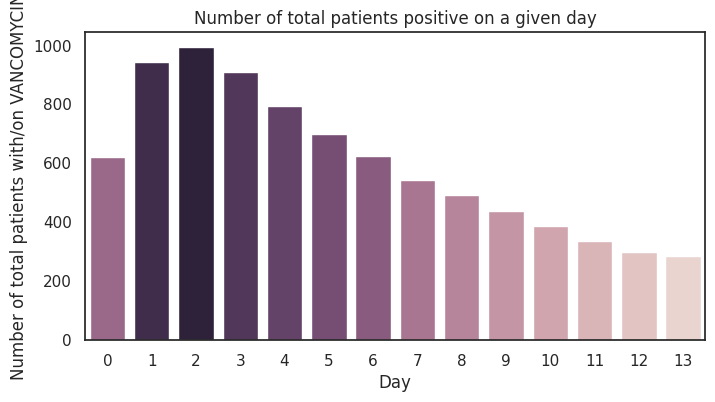

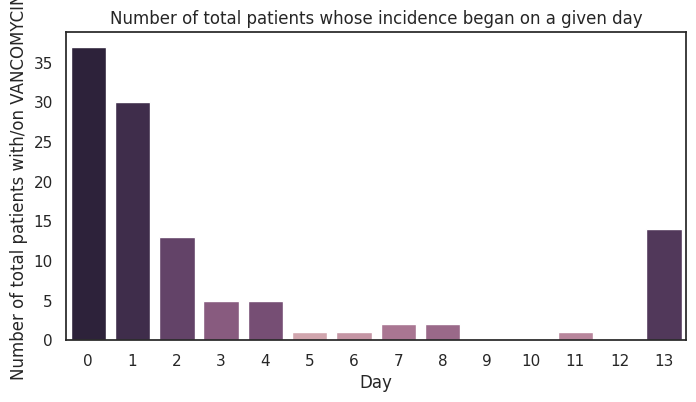

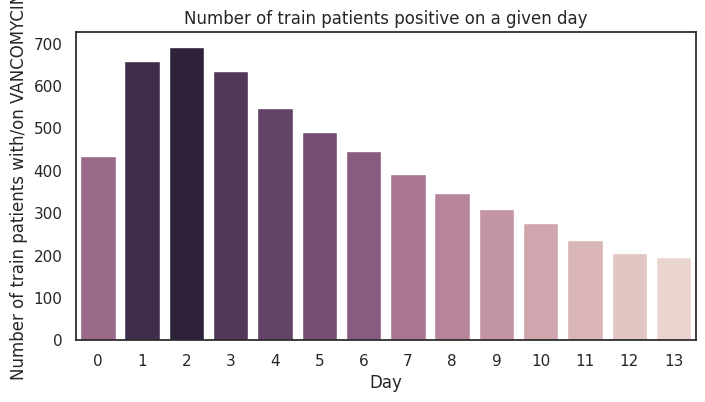

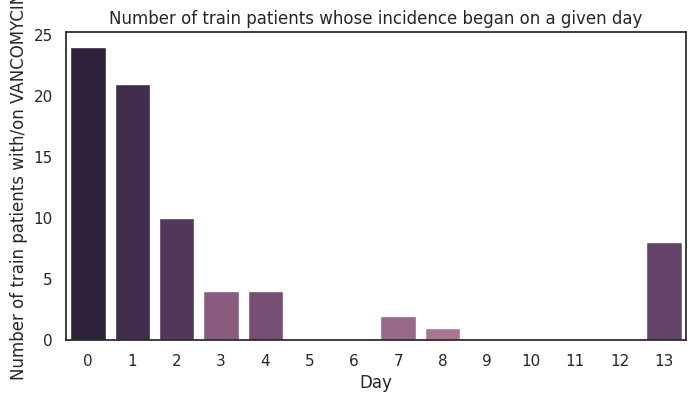

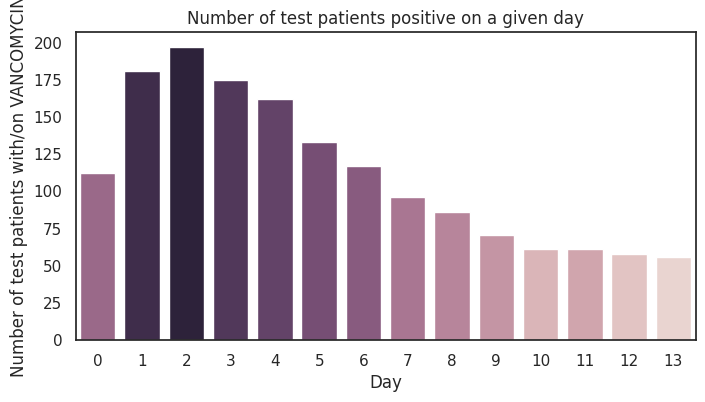

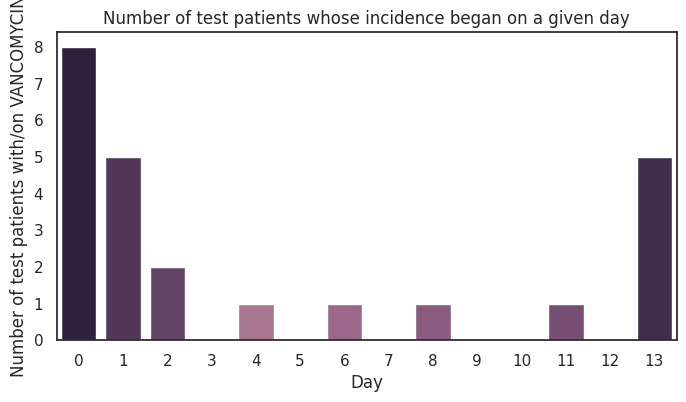

In [ ]:
############################
## SUPPLEMENTARY FIGURE 1 ##
############################

sns.set(style="white")
sns.despine(left=True, bottom=True)

## TOTAL

### When do people have incidents?

# number of people who are positive on a given day
plt.figure(figsize = (8,4))
plt.title('Number of total patients positive on a given day')
plt.ylabel('Number of total patients with/on {0}'.format(target))
plt.xlabel('Day')
y_vector_total = np.nansum(Y_TOTAL, axis=0).squeeze()
print("The total kurtosis is {0} with {1} % of events \
occuring between days 0 and 2".format(kurtosis(y_vector_total),
                                            100*int(np.sum(y_vector_total[0:2]))/np.sum(y_vector_total)))
color_rank = np.argsort(np.argsort(y_vector_total))
sns.barplot(y=y_vector_total, x=np.arange(14), palette=np.array(color_list)[color_rank])

plt.savefig(ROOT+'figures/{0}_Total_Patients_Positive_Supplemental_Figure_1.eps'.format(target), format='eps',
             dpi=300, bbox_inches='tight')

# first incident - number of people who had their first incident on a given day
plt.figure(figsize = (8,4))
plt.title('Number of total patients whose incidence began on a given day')
plt.ylabel('Number of total patients with/on {0}'.format(target))
plt.xlabel('Day')
POS_Y_TOTAL = Y_TOTAL[np.nansum(Y_TOTAL.squeeze(), axis=1) == 1]
(days_total, value_counts_total) = np.unique(np.nanargmax(POS_Y_TOTAL, axis=1), return_counts=True)
day_value_dict_total = dict(zip(np.arange(14), np.zeros(14)))
for i in range(len(days_total)):
    day_value_dict_total[days_total[i]] = value_counts_total[i]
y_vector_total_pos = list(day_value_dict_total.values())
color_rank = np.argsort(np.argsort(y_vector_total_pos))
sns.barplot(y=y_vector_total_pos, x=np.arange(14), palette=np.array(color_list)[color_rank])
#plt.show()

plt.savefig(ROOT+'figures/{0}_Total_Patients_First_Positive_Supplemental_Figure_1.eps'.format(target),
            format='eps', dpi=300, bbox_inches='tight')

## TRAIN

## When do people have incidents?

# number of people who are positive on a given day
plt.figure(figsize = (8,4))
plt.title('Number of train patients positive on a given day')
plt.ylabel('Number of train patients with/on {0}'.format(target))
plt.xlabel('Day')
y_vector_train = np.nansum(Y_TRAIN, axis=0).squeeze()
print("The train kurtosis is {0} with {1} % of events \
occuring between days 0 and 2".format(kurtosis(y_vector_train),
                                            100*int(np.sum(y_vector_train[0:2]))/np.sum(y_vector_train)))
color_rank = np.argsort(np.argsort(y_vector_train))
sns.barplot(y=y_vector_train, x=np.arange(14), palette=np.array(color_list)[color_rank])

plt.savefig(ROOT+'figures/{0}_Train_Patients_Positive_Supplemental_Figure_1.eps'.format(target), format='eps',
             dpi=300, bbox_inches='tight')


# first incident - number of people who had their first incident on a given day
plt.figure(figsize = (8,4))
plt.title('Number of train patients whose incidence began on a given day')
plt.ylabel('Number of train patients with/on {0}'.format(target))
plt.xlabel('Day')
POS_Y_TRAIN = Y_TRAIN[np.nansum(Y_TRAIN.squeeze(), axis=1) == 1]
(days_train_pos, value_counts_train_pos) = np.unique(np.nanargmax(POS_Y_TRAIN, axis=1), return_counts=True)
day_value_dict_train_pos = dict(zip(np.arange(14), np.zeros(14)))
for i in range(len(days_train_pos)):
    day_value_dict_train_pos[days_train_pos[i]] = value_counts_train_pos[i]
y_vector_train_pos = list(day_value_dict_train_pos.values())
color_rank = np.argsort(np.argsort(y_vector_train_pos))
sns.barplot(y=y_vector_train_pos, x=np.arange(14), palette=np.array(color_list)[color_rank])

plt.savefig(ROOT+'figures/{0}_Train_Patients_First_Positive_Supplemental_Figure_1.eps'.format(target),
            format='eps', dpi=300, bbox_inches='tight')

## TEST

# number of people who are positive on a given day
plt.figure(figsize = (8,4))
plt.title('Number of test patients positive on a given day')
plt.ylabel('Number of test patients with/on {0}'.format(target))
plt.xlabel('Day')
y_vector_test = np.nansum(Y_TEST, axis=0).squeeze()
print("The test kurtosis is {0} with {1} % of events \
occuring between days 0 and 2".format(kurtosis(y_vector_test),
                                          100*int(np.sum(y_vector_test[0:2]))/np.sum(y_vector_test)))
color_rank = np.argsort(np.argsort(y_vector_test))
sns.barplot(y=y_vector_test, x=np.arange(14), palette=np.array(color_list)[color_rank])

plt.savefig(ROOT+'figures/{0}_Test_Patients_Positive_Supplemental_Figure_1.eps'.format(target),
            format='eps', dpi=300, bbox_inches='tight')

# first incident - nmber of people who had their first incident on a given day
plt.figure(figsize = (8,4))
plt.title('Number of test patients whose incidence began on a given day')
plt.ylabel('Number of test patients with/on {0}'.format(target))
plt.xlabel('Day')
POS_Y_TEST = Y_TEST[np.nansum(Y_TEST.squeeze(), axis=1) == 1]
(days, value_counts) = np.unique(np.nanargmax(POS_Y_TEST, axis=1), return_counts=True)
day_value_dict = dict(zip(np.arange(14), np.zeros(14)))
for i in range(len(days)):
    day_value_dict[days[i]] = value_counts[i]
y_vector_test_pos = list(day_value_dict.values())
color_rank = np.argsort(np.argsort(y_vector_test_pos))
sns.barplot(y=y_vector_test_pos, x=np.arange(14), palette=np.array(color_list)[color_rank])

plt.savefig(ROOT+'figures/{0}_Test_Patients_First_Positive_Supplemental_Figure_1.eps'.format(target),
            format='eps', dpi=300, bbox_inches='tight')

In [ ]:
#############################
## SUPPLEMENTARY FIGURE 2 ###
#############################

X_TEST_MASK = np.copy(X_TEST)
X_TEST_MASK[x_boolmat_test] = 0
Y_PRED_mask_0 = m.predict(X_TEST_MASK)
del X_TEST_MASK

X_TEST_MASK = np.copy(X_TEST)
X_TEST_MASK[x_boolmat_test] = 0
Y_PRED_80_percent = m_80.predict(X_TEST_MASK)
del X_TEST_MASK

X_TEST_MASK = np.copy(X_TEST)
X_TEST_MASK[x_boolmat_test] = 0
Y_PRED_60_percent = m_60.predict(X_TEST_MASK)
del X_TEST_MASK

X_TEST_MASK = np.copy(X_TEST)
X_TEST_MASK[x_boolmat_test] = 0
Y_PRED_40_percent = m_40.predict(X_TEST_MASK)
del X_TEST_MASK

X_TEST_MASK = np.copy(X_TEST)
X_TEST_MASK[x_boolmat_test] = 0
Y_PRED_20_percent = m_20.predict(X_TEST_MASK)
del X_TEST_MASK

X_TEST_MASK = np.copy(X_TEST)
X_TEST_MASK[x_boolmat_test] = 0
Y_PRED_10_percent = m_10.predict(X_TEST_MASK)
del X_TEST_MASK

X_TEST_MASK = np.copy(X_TEST)
X_TEST_MASK[x_boolmat_test] = 0
Y_PRED_5_percent = m_5.predict(X_TEST_MASK)
del X_TEST_MASK

# AUROC values with models that have been trained with various fractions of training data

28/28 [==============================] - 2s 20ms/step


In [ ]:
#############################
## SUPPLEMENTARY FIGURE 2 ###
#############################

(fpr_100, tpr_100, thresholds_100) = roc_curve(Y_TEST[~y_boolmat_test], Y_PRED_mask_0[~y_boolmat_test])
(fpr_80, tpr_80, thresholds_80) = roc_curve(Y_TEST[~y_boolmat_test], Y_PRED_80_percent[~y_boolmat_test])
(fpr_60, tpr_60, thresholds_60) = roc_curve(Y_TEST[~y_boolmat_test], Y_PRED_60_percent[~y_boolmat_test])
(fpr_40, tpr_40, thresholds_40) = roc_curve(Y_TEST[~y_boolmat_test], Y_PRED_40_percent[~y_boolmat_test])
(fpr_20, tpr_20, thresholds_20) = roc_curve(Y_TEST[~y_boolmat_test], Y_PRED_20_percent[~y_boolmat_test])
(fpr_10, tpr_10, thresholds_10) = roc_curve(Y_TEST[~y_boolmat_test], Y_PRED_10_percent[~y_boolmat_test])
(fpr_5, tpr_5, thresholds_5) = roc_curve(Y_TEST[~y_boolmat_test], Y_PRED_5_percent[~y_boolmat_test])

fpr_tprs = [(fpr_100, tpr_100), (fpr_80, tpr_80), (fpr_60, tpr_60),
            (fpr_40, tpr_40), (fpr_20, tpr_20), (fpr_10, tpr_10), (fpr_5, tpr_5)]

0.8654588972500161
0.830605056184937
0.8041454192967464
0.7715713635987761
0.6932611956411882
0.6578407389031303
0.5846923610536857
PPV for full model is 0.6178343949044586
Sensitivity for full model is 0.62
              precision    recall  f1-score   support

         0.0       0.89      0.89      0.89      5560
         1.0       0.62      0.62      0.62      1566

    accuracy                           0.83      7126
   macro avg       0.76      0.76      0.76      7126
weighted avg       0.83      0.83      0.83      7126



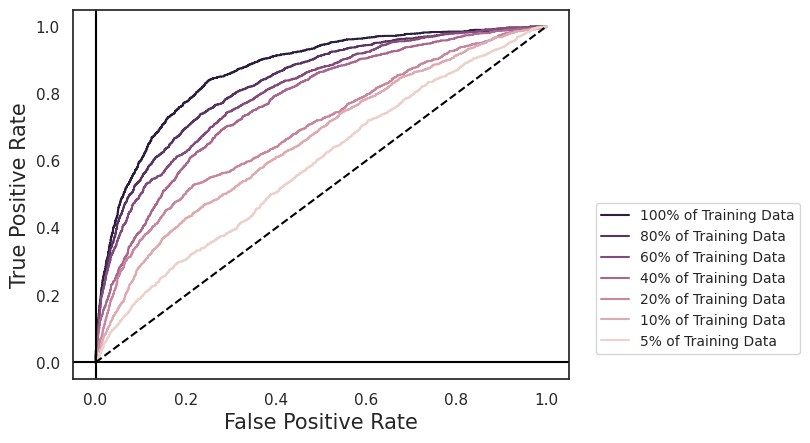

In [ ]:
#############################
## SUPPLEMENTARY FIGURE 2 ###
#############################

fig, ax = plt.subplots()
ax.set_facecolor('white')

for color, fpr_tpr_tuple, i in zip(np.array(color_list_reduced)[::-1], fpr_tprs, [100,80,60,40,20,10,5]):
    plt.plot(fpr_tpr_tuple[0], fpr_tpr_tuple[1], label='{0}% of Training Data'.format(i), color=color)

plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.axhline(0, color='black')
plt.axvline(0, color='black')
legend = plt.legend(loc="lower right", prop={'size': 10}, bbox_to_anchor=(1.48, 0.05))
plt.savefig(ROOT+'figures/{0}_less_data_roc_curves_Supplemental_Figure_2.eps'.format(target), format='eps',
             dpi=300, facecolor='white', transparent=True, bbox_extra_artists=(legend,), bbox_inches='tight')

# 100 % Training Data
print(roc_auc_score(Y_TEST[~y_boolmat_test], Y_PRED_mask_0[~y_boolmat_test]))
# 80 % Training Data
print(roc_auc_score(Y_TEST[~y_boolmat_test], Y_PRED_80_percent[~y_boolmat_test]))
# 60 % Training Data
print(roc_auc_score(Y_TEST[~y_boolmat_test], Y_PRED_60_percent[~y_boolmat_test]))
# 40 % Training Data
print(roc_auc_score(Y_TEST[~y_boolmat_test], Y_PRED_40_percent[~y_boolmat_test]))
# 20 % Training Data
print(roc_auc_score(Y_TEST[~y_boolmat_test], Y_PRED_20_percent[~y_boolmat_test]))
# 10 % Training Data
print(roc_auc_score(Y_TEST[~y_boolmat_test], Y_PRED_10_percent[~y_boolmat_test]))
# 5 % Training Data
print(roc_auc_score(Y_TEST[~y_boolmat_test], Y_PRED_5_percent[~y_boolmat_test]))

## 100% Training Data ##
TN, FP, FN, TP = confusion_matrix(Y_TEST[~y_boolmat_test], np.around(Y_PRED_mask_0[~y_boolmat_test])).ravel()
PPV = TP/(TP+FP)
print("PPV for full model is {0}".format(PPV))
CR = classification_report(Y_TEST[~y_boolmat_test], np.around(Y_PRED_mask_0[~y_boolmat_test]))

print("Sensitivity for full model is {0}".format(CR.split('\n')[3].split()[2]))
# classification_report(Y_TEST[~y_boolmat_test], np.around(Y_PRED_mask_0[~y_boolmat_test]))

print(classification_report(Y_TEST[~y_boolmat_test], np.around(Y_PRED_mask_0[~y_boolmat_test])))

In [ ]:
# GET ACTIVATIONS MATRIX ; OUTPUT IS (BATCH_SIZE, TIME_STEPS, FEATURES)

activations = get_activations(m, X_TEST, print_shape_only=True, layer_name='attention_vec')[0]
activations[x_boolmat_test] = np.nan

# AVERAGE THE ATTENTION MATRIX OVER FEATURES ; OUTPUT IS BATCH_SIZE, TIME_STEPS
attention_matrix = np.nanmean(activations, axis=2).squeeze()

# AVERAGE ATTENTION VECTOR ACROSS SAMPLES ; OUTPUT IS 1D TIME_STEPS
attention_vector_final = np.nanmean(attention_matrix, axis=0)

# This allows us to rank color intensity by activation. We sort the intensities, then argsort the indices ##
color_order = np.argsort(attention_vector_final, axis=0)
color_order_order = np.argsort(color_order)

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(
<ipython-input-18-02a72c2243f8>:7: RuntimeWarning: Mean of empty slice
  attention_matrix = np.nanmean(activations, axis=2).squeeze()


In [ ]:
attention_vector_final

array([0.11070997, 0.08240684, 0.07261151, 0.07531828, 0.0732663 ,
       0.06822907, 0.07424092, 0.06119041, 0.0627242 , 0.05697154,
       0.0703107 , 0.0605517 , 0.05801575, 0.0556393 ], dtype=float32)

In [ ]:
''' Due to the way features are selectd from the EMR and the fact potassium can be a
delivered medication or a lab value, special care was taken to ensure proper representation on heatmaps '''

if 'digoxin(?!.*fab)' in features:
    indexy = features.index('digoxin(?!.*fab)')
    features[indexy] = 'digoxin'

if 'potassium_y' in features:
    indexy = features.index('potassium_y')
    features[indexy] = 'potassium_med'

if 'potassium_x' in features:
    indexy = features.index('potassium_x')
    features[indexy] = 'potassium'

if 'cipfloxacin' in features:
    indexy = features.index('cipfloxacin')
    features[indexy] = 'ciprofloxacin'

features = [feature.lower() for feature in features]

In [ ]:
## FEATURES BY CATEGORY ##

cbc_diff_features = ['RBCs', 'WBCs', 'platelets', 'hemoglobin', 'hemocrit',
                              'atypical lymphocytes', 'bands', 'basophils', 'eosinophils', 'neutrophils',
                              'lymphocytes', 'monocytes', 'polymorphonuclear leukocytes']

vital_features = ['temperature (F)', 'heart rate', 'respiratory rate', 'systolic', 'diastolic',
                  'pulse oximetry']

lab_features = ['troponin', 'HDL', 'LDL', 'BUN', 'INR', 'PTT', 'PT', 'triglycerides', 'creatinine',
                  'glucose', 'sodium', 'potassium', 'chloride', 'bicarbonate',
                  'blood culture', 'urine culture', 'surface culture', 'sputum' +
                  ' culture', 'wound culture', 'Inspired O2 Fraction', 'central venous pressure',
                  'PEEP Set', 'tidal volume', 'anion gap']

demographic_features = ['age', 'm', 'black', 'daily weight', 'tobacco', 'diabetes', 'history of CV events']

med_features = ['epoetin', 'warfarin', 'heparin', 'enoxaparin', 'fondaparinux',
                                      'asprin', 'ketorolac', 'acetominophen',
                                      'insulin', 'glucagon',
                                      'potassium_med', 'calcium gluconate',
                                      'fentanyl', 'magensium sulfate',
                                      'D5W', 'dextrose',
                                      'ranitidine', 'ondansetron', 'pantoprazole', 'metoclopramide',
                                      'lisinopril', 'captopril', 'statin',
                                      'hydralazine', 'diltiazem',
                                      'carvedilol', 'metoprolol', 'labetalol', 'atenolol',
                                      'amiodarone', 'digoxin',
                                      'clopidogrel', 'nitroprusside', 'nitroglycerin',
                                      'vasopressin', 'hydrochlorothiazide', 'furosemide',
                                      'atropine', 'neostigmine',
                                      'levothyroxine',
                                      'oxycodone', 'hydromorphone', 'fentanyl citrate',
                                      'tacrolimus', 'prednisone',
                                      'phenylephrine', 'norepinephrine',
                                      'haloperidol', 'phenytoin', 'trazodone', 'levetiracetam',
                                      'diazepam', 'clonazepam',
                                      'propofol', 'zolpidem', 'midazolam',
                                      'albuterol', 'ipratropium',
                                      'diphenhydramine',
                                      '0.9% Sodium Chloride',
                                      'phytonadione',
                                      'metronidazole',
                                      'cefazolin', 'cefepime', 'vancomycin', 'levofloxacin',
                                      'ciprofloxacin', 'fluconazole',
                                      'meropenem', 'ceftriaxone', 'piperacillin',
                                      'ampicillin-sulbactam', 'nafcillin', 'oxacillin',
                                      'amoxicillin', 'penicillin', 'SMX-TMP']

cbc_diff_features = [[i.lower(), i.lower()+'_min', i.lower()+'_max', i.lower()+'_std'] for i in cbc_diff_features]
vital_features = [[i.lower(), i.lower()+'_min', i.lower()+'_max', i.lower()+'_std'] for i in vital_features]
lab_features = [[i.lower(), i.lower()+'_min', i.lower()+'_max', i.lower()+'_std'] for i in lab_features]
demographic_features = [i.lower() for i in demographic_features]
med_features = [i.lower() for i in med_features]

cbc_diff_feature_array = np.array(cbc_diff_features).flatten()
vital_features_array = np.array(vital_features).flatten()
lab_features_array = np.array(lab_features).flatten()
demographic_feature_array = np.array(demographic_features).flatten()
med_features_array = np.array(med_features).flatten()

features_built = np.hstack([cbc_diff_feature_array,vital_features_array,
                            lab_features_array,demographic_feature_array,med_features_array])

features_built_reduced = [i for i in features_built if i in features]

In [ ]:
## Identifies the index in the features list in the desired order ##
arranged_indices = [features.index(i) for i in features_built_reduced]

In [ ]:
## This is a sanity check to ensure that features_built_reduced has the same number of elements as our target ##

print(len(features_SEPSIS))
print(len(features_MI))
print(len(features_VANCOMYCIN))
print('\n')
print(len(features_built))
print(len(features_built_reduced))

224
220
223


256
223


##   Evaluation

For evaluation we are primarily utilizing the AUC score to identify the true positive and false positive rates of the model. We have also included additional information for feature activiations as suppementary material. Please see the results section for more details.

Display Evaluation Results for VANCOMYCIN

In [ ]:
##############
## FIGURE 1 ##
##############

X_TEST_MASK = np.copy(X_TEST)
X_TEST_MASK[x_boolmat_test] = 0
Y_PRED_mask_0 = m.predict(X_TEST_MASK)
del X_TEST_MASK

X_TEST_MASK = np.copy(X_TEST)
mask = 1
X_TEST_MASK[x_boolmat_test] = 0
X_TEST_MASK[:,mask:,:] = 0
Y_PRED_mask_1 = m.predict(X_TEST_MASK)
del X_TEST_MASK

X_TEST_MASK = np.copy(X_TEST)
mask = 2
X_TEST_MASK[x_boolmat_test] = 0
X_TEST_MASK[:,mask:,:] = 0
Y_PRED_mask_2 = m.predict(X_TEST_MASK)
del X_TEST_MASK

X_TEST_MASK = np.copy(X_TEST)
mask = 3
X_TEST_MASK[x_boolmat_test] = 0
X_TEST_MASK[:,mask:,:] = 0
Y_PRED_mask_3 = m.predict(X_TEST_MASK)
del X_TEST_MASK

X_TEST_MASK = np.copy(X_TEST)
mask = 4
X_TEST_MASK[x_boolmat_test] = 0
X_TEST_MASK[:,mask:,:] = 0
Y_PRED_mask_4 = m.predict(X_TEST_MASK)
del X_TEST_MASK

X_TEST_MASK = np.copy(X_TEST)
mask = 5
X_TEST_MASK[x_boolmat_test] = 0
X_TEST_MASK[:,mask:,:] = 0
Y_PRED_mask_5 = m.predict(X_TEST_MASK)
del X_TEST_MASK

X_TEST_MASK = np.copy(X_TEST)
mask = 6
X_TEST_MASK[x_boolmat_test] = 0
X_TEST_MASK[:,mask:,:] = 0
Y_PRED_mask_6 = m.predict(X_TEST_MASK)
del X_TEST_MASK

X_TEST_MASK = np.copy(X_TEST)
mask = 7
X_TEST_MASK[x_boolmat_test] = 0
X_TEST_MASK[:,mask:,:] = 0
Y_PRED_mask_7 = m.predict(X_TEST_MASK)
del X_TEST_MASK

X_TEST_MASK = np.copy(X_TEST)
mask = 8
X_TEST_MASK[x_boolmat_test] = 0
X_TEST_MASK[:,mask:,:] = 0
Y_PRED_mask_8 = m.predict(X_TEST_MASK)
del X_TEST_MASK

X_TEST_MASK = np.copy(X_TEST)
mask = 9
X_TEST_MASK[x_boolmat_test] = 0
X_TEST_MASK[:,mask:,:] = 0
Y_PRED_mask_9 = m.predict(X_TEST_MASK)
del X_TEST_MASK

X_TEST_MASK = np.copy(X_TEST)
mask = 10
X_TEST_MASK[x_boolmat_test] = 0
X_TEST_MASK[:,mask:,:] = 0
Y_PRED_mask_10 = m.predict(X_TEST_MASK)
del X_TEST_MASK

X_TEST_MASK = np.copy(X_TEST)
mask = 11
X_TEST_MASK[x_boolmat_test] = 0
X_TEST_MASK[:,mask:,:] = 0
Y_PRED_mask_11 = m.predict(X_TEST_MASK)
del X_TEST_MASK

X_TEST_MASK = np.copy(X_TEST)
mask = 12
X_TEST_MASK[x_boolmat_test] = 0
X_TEST_MASK[:,mask:,:] = 0
Y_PRED_mask_12 = m.predict(X_TEST_MASK)
del X_TEST_MASK

X_TEST_MASK = np.copy(X_TEST)
mask = 13
X_TEST_MASK[x_boolmat_test] = 0
X_TEST_MASK[:,mask:,:] = 0
Y_PRED_mask_13 = m.predict(X_TEST_MASK)
del X_TEST_MASK

28/28 [==============================] - 1s 20ms/step


In [ ]:
##############
## FIGURE 1 ##
##############

(fpr_mask_0, tpr_mask_0, thresholds_mask_0) = roc_curve(Y_TEST[~y_boolmat_test], Y_PRED_mask_0[~y_boolmat_test])
(fpr_mask_1, tpr_mask_1, thresholds_mask_1) = roc_curve(Y_TEST[~y_boolmat_test], Y_PRED_mask_1[~y_boolmat_test])
(fpr_mask_2, tpr_mask_2, thresholds_mask_2) = roc_curve(Y_TEST[~y_boolmat_test], Y_PRED_mask_2[~y_boolmat_test])
(fpr_mask_3, tpr_mask_3, thresholds_mask_3) = roc_curve(Y_TEST[~y_boolmat_test], Y_PRED_mask_3[~y_boolmat_test])
(fpr_mask_4, tpr_mask_4, thresholds_mask_4) = roc_curve(Y_TEST[~y_boolmat_test], Y_PRED_mask_4[~y_boolmat_test])
(fpr_mask_5, tpr_mask_5, thresholds_mask_5) = roc_curve(Y_TEST[~y_boolmat_test], Y_PRED_mask_5[~y_boolmat_test])
(fpr_mask_6, tpr_mask_6, thresholds_mask_6) = roc_curve(Y_TEST[~y_boolmat_test], Y_PRED_mask_6[~y_boolmat_test])
(fpr_mask_7, tpr_mask_7, thresholds_mask_7) = roc_curve(Y_TEST[~y_boolmat_test], Y_PRED_mask_7[~y_boolmat_test])
(fpr_mask_8, tpr_mask_8, thresholds_mask_8) = roc_curve(Y_TEST[~y_boolmat_test], Y_PRED_mask_8[~y_boolmat_test])
(fpr_mask_9, tpr_mask_9, thresholds_mask_9) = roc_curve(Y_TEST[~y_boolmat_test], Y_PRED_mask_9[~y_boolmat_test])
(fpr_mask_10, tpr_mask_10, thresholds_mask_10) = roc_curve(Y_TEST[~y_boolmat_test], Y_PRED_mask_10[~y_boolmat_test])
(fpr_mask_11, tpr_mask_11, thresholds_mask_11) = roc_curve(Y_TEST[~y_boolmat_test], Y_PRED_mask_11[~y_boolmat_test])
(fpr_mask_12, tpr_mask_12, thresholds_mask_12) = roc_curve(Y_TEST[~y_boolmat_test], Y_PRED_mask_12[~y_boolmat_test])
(fpr_mask_13, tpr_mask_13, thresholds_mask_13) = roc_curve(Y_TEST[~y_boolmat_test], Y_PRED_mask_13[~y_boolmat_test])

fpr_tprs = [(fpr_mask_1, tpr_mask_1), (fpr_mask_2, tpr_mask_2), (fpr_mask_3, tpr_mask_3), (fpr_mask_4, tpr_mask_4),
            (fpr_mask_5, tpr_mask_5), (fpr_mask_6, tpr_mask_6), (fpr_mask_7, tpr_mask_7), (fpr_mask_8, tpr_mask_8),
            (fpr_mask_9, tpr_mask_9), (fpr_mask_10, tpr_mask_10), (fpr_mask_11, tpr_mask_11), (fpr_mask_12, tpr_mask_12),
            (fpr_mask_13, tpr_mask_13), (fpr_mask_0, tpr_mask_0)]

print(roc_auc_score(Y_TEST[~y_boolmat_test], Y_PRED_mask_0[~y_boolmat_test]))
print(roc_auc_score(Y_TEST[~y_boolmat_test], Y_PRED_mask_13[~y_boolmat_test]))
print(roc_auc_score(Y_TEST[~y_boolmat_test], Y_PRED_mask_12[~y_boolmat_test]))
print(roc_auc_score(Y_TEST[~y_boolmat_test], Y_PRED_mask_11[~y_boolmat_test]))
print(roc_auc_score(Y_TEST[~y_boolmat_test], Y_PRED_mask_10[~y_boolmat_test]))
print(roc_auc_score(Y_TEST[~y_boolmat_test], Y_PRED_mask_9[~y_boolmat_test]))
print(roc_auc_score(Y_TEST[~y_boolmat_test], Y_PRED_mask_8[~y_boolmat_test]))
print(roc_auc_score(Y_TEST[~y_boolmat_test], Y_PRED_mask_7[~y_boolmat_test]))
print(roc_auc_score(Y_TEST[~y_boolmat_test], Y_PRED_mask_6[~y_boolmat_test]))
print(roc_auc_score(Y_TEST[~y_boolmat_test], Y_PRED_mask_5[~y_boolmat_test]))
print(roc_auc_score(Y_TEST[~y_boolmat_test], Y_PRED_mask_4[~y_boolmat_test]))
print(roc_auc_score(Y_TEST[~y_boolmat_test], Y_PRED_mask_3[~y_boolmat_test]))
print(roc_auc_score(Y_TEST[~y_boolmat_test], Y_PRED_mask_2[~y_boolmat_test]))
print(roc_auc_score(Y_TEST[~y_boolmat_test], Y_PRED_mask_1[~y_boolmat_test]))

0.8654588972500161
0.8656182525244172
0.8647635340003859
0.8531716006505141
0.8549180770326268
0.8549781439216443
0.8472951523838401
0.833000840706745
0.8182218592941738
0.8155280373402427
0.7884706028280825
0.7601759397080037
0.7273927984049542
0.6588877174122771


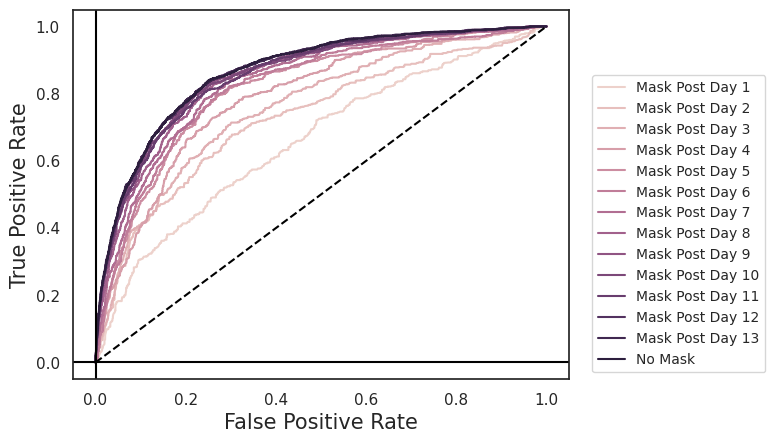

In [ ]:
##############
## FIGURE 1 ##
##############

fig, ax = plt.subplots()
ax.set_facecolor('white')

counter = 1

for color, fpr_tpr_tuple in zip(color_list, fpr_tprs):
    if counter != 14:
        plt.plot(fpr_tpr_tuple[0], fpr_tpr_tuple[1], label='Mask Post Day {0}'.format(counter), color=color)
        counter = counter+1
    elif counter == 14:
        plt.plot(fpr_tpr_tuple[0], fpr_tpr_tuple[1], label='No Mask', color=color)

plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.axhline(0, color='black')
plt.axvline(0, color='black')
legend = plt.legend(loc="lower right", prop={'size': 10}, bbox_to_anchor=(1.41, 0))
plt.savefig(ROOT+'figures/{0}_roc_curves_Fig_1.eps'.format(target), format='eps',
             dpi=300, facecolor='white', transparent=True, bbox_extra_artists=(legend,), bbox_inches='tight')

In [ ]:
##############################
## FIGURE 2 LAG EXPERIMENTS ##
##############################

### 1 DAY LAGGED EXPERIMENTS ###

### Y_PRED_mask_0_LAG_1 ###

Y_PRED_mask_0_LAG_1 = np.concatenate([Y_PRED_mask_0[:,i][~y_boolmat_test[:,i,:]] for i in range(1,13)], axis=0)
Y_PRED_mask_0_LAG_2 = np.concatenate([Y_PRED_mask_0[:,i][~y_boolmat_test[:,i,:]] for i in range(2,13)], axis=0)
Y_PRED_mask_0_LAG_3 = np.concatenate([Y_PRED_mask_0[:,i][~y_boolmat_test[:,i,:]] for i in range(3,13)], axis=0)
Y_PRED_mask_0_LAG_4 = np.concatenate([Y_PRED_mask_0[:,i][~y_boolmat_test[:,i,:]] for i in range(4,13)], axis=0)
Y_PRED_mask_0_LAG_5 = np.concatenate([Y_PRED_mask_0[:,i][~y_boolmat_test[:,i,:]] for i in range(5,13)], axis=0)
Y_PRED_mask_0_LAG_6 = np.concatenate([Y_PRED_mask_0[:,i][~y_boolmat_test[:,i,:]] for i in range(6,13)], axis=0)
Y_PRED_mask_0_LAG_7 = np.concatenate([Y_PRED_mask_0[:,i][~y_boolmat_test[:,i,:]] for i in range(7,13)], axis=0)

# below is an equivalent representation

# Y_PRED_mask_0_LAG_1 = np.concatenate([Y_PRED_mask_0[:,1][~y_boolmat_test[:,1,::]],
#                                     Y_PRED_mask_0[:,2][~y_boolmat_test[:,2,::]],
#                                     Y_PRED_mask_0[:,3][~y_boolmat_test[:,3,::]],
#                                     Y_PRED_mask_0[:,4][~y_boolmat_test[:,4,::]],
#                                     Y_PRED_mask_0[:,5][~y_boolmat_test[:,5,::]],
#                                     Y_PRED_mask_0[:,6][~y_boolmat_test[:,6,::]],
#                                     Y_PRED_mask_0[:,7][~y_boolmat_test[:,7,::]],
#                                     Y_PRED_mask_0[:,8][~y_boolmat_test[:,8,::]],
#                                     Y_PRED_mask_0[:,9][~y_boolmat_test[:,9,::]],
#                                     Y_PRED_mask_0[:,10][~y_boolmat_test[:,10,::]],
#                                     Y_PRED_mask_0[:,11][~y_boolmat_test[:,11,::]],
#                                     Y_PRED_mask_0[:,12][~y_boolmat_test[:,12,::]],
#                                     Y_PRED_mask_0[:,13][~y_boolmat_test[:,13,::]]], axis=0)

### all the first day soft every person, all the second days, third days, in a 1D vector

Y_TEST_LAG_1 = np.concatenate([Y_TEST[:,i][~y_boolmat_test[:,i,::]] for i in range(1,14)], axis=0)
Y_TEST_LAG_2 = np.concatenate([Y_TEST[:,i][~y_boolmat_test[:,i,::]] for i in range(2,14)], axis=0)
Y_TEST_LAG_3 = np.concatenate([Y_TEST[:,i][~y_boolmat_test[:,i,::]] for i in range(3,14)], axis=0)
Y_TEST_LAG_4 = np.concatenate([Y_TEST[:,i][~y_boolmat_test[:,i,::]] for i in range(4,14)], axis=0)
Y_TEST_LAG_5 = np.concatenate([Y_TEST[:,i][~y_boolmat_test[:,i,::]] for i in range(5,14)], axis=0)
Y_TEST_LAG_6 = np.concatenate([Y_TEST[:,i][~y_boolmat_test[:,i,::]] for i in range(6,14)], axis=0)
Y_TEST_LAG_7 = np.concatenate([Y_TEST[:,i][~y_boolmat_test[:,i,::]] for i in range(7,14)], axis=0)

#############
## Y_PREDS ##
#############

Y_PRED_LAG_1 = np.concatenate([Y_PRED_mask_1[:,1,::][~y_boolmat_test[:,1,::]],
                             Y_PRED_mask_2[:,2,::][~y_boolmat_test[:,2,::]],
                             Y_PRED_mask_3[:,3,::][~y_boolmat_test[:,3,::]],
                             Y_PRED_mask_4[:,4,::][~y_boolmat_test[:,4,:]],
                             Y_PRED_mask_5[:,5,::][~y_boolmat_test[:,5,::]],
                             Y_PRED_mask_6[:,6,::][~y_boolmat_test[:,6,::]],
                             Y_PRED_mask_7[:,7,::][~y_boolmat_test[:,7,::]],
                             Y_PRED_mask_8[:,8,::][~y_boolmat_test[:,8,::]],
                             Y_PRED_mask_9[:,9,::][~y_boolmat_test[:,9,::]],
                             Y_PRED_mask_10[:,10,::][~y_boolmat_test[:,10,::]],
                             Y_PRED_mask_11[:,11,::][~y_boolmat_test[:,11,::]],
                             Y_PRED_mask_12[:,12,::][~y_boolmat_test[:,12,::]],
                             Y_PRED_mask_13[:,13,::][~y_boolmat_test[:,13,::]]], axis=0)

Y_PRED_LAG_2 = np.concatenate([Y_PRED_mask_1[:,2,::][~y_boolmat_test[:,2,::]],
                             Y_PRED_mask_2[:,3,::][~y_boolmat_test[:,3,::]],
                             Y_PRED_mask_3[:,4,::][~y_boolmat_test[:,4,::]],
                             Y_PRED_mask_4[:,5,::][~y_boolmat_test[:,5,:]],
                             Y_PRED_mask_5[:,6,::][~y_boolmat_test[:,6,::]],
                             Y_PRED_mask_6[:,7,::][~y_boolmat_test[:,7,::]],
                             Y_PRED_mask_7[:,8,::][~y_boolmat_test[:,8,::]],
                             Y_PRED_mask_8[:,9,::][~y_boolmat_test[:,9,::]],
                             Y_PRED_mask_9[:,10,::][~y_boolmat_test[:,10,::]],
                             Y_PRED_mask_10[:,11,::][~y_boolmat_test[:,11,::]],
                             Y_PRED_mask_11[:,12,::][~y_boolmat_test[:,12,::]],
                             Y_PRED_mask_12[:,13,::][~y_boolmat_test[:,13,::]]], axis=0)

Y_PRED_LAG_3 = np.concatenate([Y_PRED_mask_1[:,3,::][~y_boolmat_test[:,3,::]],
                             Y_PRED_mask_2[:,4,::][~y_boolmat_test[:,4,::]],
                             Y_PRED_mask_3[:,5,::][~y_boolmat_test[:,5,::]],
                             Y_PRED_mask_4[:,6,::][~y_boolmat_test[:,6,:]],
                             Y_PRED_mask_5[:,7,::][~y_boolmat_test[:,7,::]],
                             Y_PRED_mask_6[:,8,::][~y_boolmat_test[:,8,::]],
                             Y_PRED_mask_7[:,9,::][~y_boolmat_test[:,9,::]],
                             Y_PRED_mask_8[:,10,::][~y_boolmat_test[:,10,::]],
                             Y_PRED_mask_9[:,11,::][~y_boolmat_test[:,11,::]],
                             Y_PRED_mask_10[:,12,::][~y_boolmat_test[:,12,::]],
                             Y_PRED_mask_11[:,13,::][~y_boolmat_test[:,13,::]]], axis=0)

Y_PRED_LAG_4 = np.concatenate([Y_PRED_mask_1[:,4,::][~y_boolmat_test[:,4,:]],
                             Y_PRED_mask_2[:,5,::][~y_boolmat_test[:,5,:]],
                             Y_PRED_mask_3[:,6,::][~y_boolmat_test[:,6,::]],
                             Y_PRED_mask_4[:,7,::][~y_boolmat_test[:,7,:]],
                             Y_PRED_mask_5[:,8,::][~y_boolmat_test[:,8,::]],
                             Y_PRED_mask_6[:,9,::][~y_boolmat_test[:,9,::]],
                             Y_PRED_mask_7[:,10,::][~y_boolmat_test[:,10,::]],
                             Y_PRED_mask_8[:,11,::][~y_boolmat_test[:,11,::]],
                             Y_PRED_mask_9[:,12,::][~y_boolmat_test[:,12,::]],
                             Y_PRED_mask_10[:,13,::][~y_boolmat_test[:,13,::]]], axis=0)

Y_PRED_LAG_5 = np.concatenate([Y_PRED_mask_1[:,5,::][~y_boolmat_test[:,5,:]],
                             Y_PRED_mask_2[:,6,::][~y_boolmat_test[:,6,:]],
                             Y_PRED_mask_3[:,7,::][~y_boolmat_test[:,7,::]],
                             Y_PRED_mask_4[:,8,::][~y_boolmat_test[:,8,:]],
                             Y_PRED_mask_5[:,9,::][~y_boolmat_test[:,9,::]],
                             Y_PRED_mask_6[:,10,::][~y_boolmat_test[:,10,::]],
                             Y_PRED_mask_7[:,11,::][~y_boolmat_test[:,10,::]],
                             Y_PRED_mask_8[:,12,::][~y_boolmat_test[:,11,::]],
                             Y_PRED_mask_9[:,13,::][~y_boolmat_test[:,12,::]]], axis=0)

Y_PRED_LAG_5 = np.concatenate([Y_PRED_mask_1[:,5,::][~y_boolmat_test[:,5,:]],
                             Y_PRED_mask_2[:,6,::][~y_boolmat_test[:,6,:]],
                             Y_PRED_mask_3[:,7,::][~y_boolmat_test[:,7,::]],
                             Y_PRED_mask_4[:,8,::][~y_boolmat_test[:,8,:]],
                             Y_PRED_mask_5[:,9,::][~y_boolmat_test[:,9,::]],
                             Y_PRED_mask_6[:,10,::][~y_boolmat_test[:,10,::]],
                             Y_PRED_mask_7[:,11,::][~y_boolmat_test[:,11,::]],
                             Y_PRED_mask_8[:,12,::][~y_boolmat_test[:,12,::]],
                             Y_PRED_mask_9[:,13,::][~y_boolmat_test[:,13,::]]], axis=0)

Y_PRED_LAG_6 = np.concatenate([Y_PRED_mask_1[:,6,::][~y_boolmat_test[:,6,:]],
                             Y_PRED_mask_2[:,7,::][~y_boolmat_test[:,7,:]],
                             Y_PRED_mask_3[:,8,::][~y_boolmat_test[:,8,::]],
                             Y_PRED_mask_4[:,9,::][~y_boolmat_test[:,9,:]],
                             Y_PRED_mask_5[:,10,::][~y_boolmat_test[:,10,::]],
                             Y_PRED_mask_6[:,11,::][~y_boolmat_test[:,11,::]],
                             Y_PRED_mask_7[:,12,::][~y_boolmat_test[:,12,::]],
                             Y_PRED_mask_8[:,13,::][~y_boolmat_test[:,13,::]]], axis=0)

Y_PRED_LAG_7 = np.concatenate([Y_PRED_mask_1[:,7,::][~y_boolmat_test[:,7,:]],
                             Y_PRED_mask_2[:,8,::][~y_boolmat_test[:,8,:]],
                             Y_PRED_mask_3[:,9,::][~y_boolmat_test[:,9,::]],
                             Y_PRED_mask_4[:,10,::][~y_boolmat_test[:,10,:]],
                             Y_PRED_mask_5[:,11,::][~y_boolmat_test[:,11,::]],
                             Y_PRED_mask_6[:,12,::][~y_boolmat_test[:,12,::]],
                             Y_PRED_mask_7[:,13,::][~y_boolmat_test[:,13,::]]], axis=0)

## LAG ROC ##

# Day 1 Lag
print(roc_auc_score(Y_TEST_LAG_1, Y_PRED_LAG_1))
# Day 2 Lag
print(roc_auc_score(Y_TEST_LAG_2, Y_PRED_LAG_2))
# # Day 3 Lag
print(roc_auc_score(Y_TEST_LAG_3, Y_PRED_LAG_3))
# Day 4 Lag
print(roc_auc_score(Y_TEST_LAG_4, Y_PRED_LAG_4))
# Day 5 Lag
print(roc_auc_score(Y_TEST_LAG_5, Y_PRED_LAG_5))
# Day 6 Lag
print(roc_auc_score(Y_TEST_LAG_6, Y_PRED_LAG_6))
# Day 6 Lag
print(roc_auc_score(Y_TEST_LAG_7, Y_PRED_LAG_7))

confusion_matrix(Y_TEST_LAG_1, np.around(Y_PRED_LAG_1))

## 100% Training Data with 1 day lag ##
TN, FP, FN, TP = confusion_matrix(Y_TEST_LAG_1, np.around(Y_PRED_LAG_1)).ravel()
PPV = TP/(TP+FP)
print("PPV for full model w/ 1 day lag is {0}".format(PPV))
CR = classification_report(Y_TEST_LAG_1, np.around(Y_PRED_LAG_1))

print("Sensitivity for full model w/ 1 day lag is {0}".format(CR.split('\n')[3].split()[2]))
# classification_report(Y_TEST[~y_boolmat_test], np.around(Y_PRED_mask_0[~y_boolmat_test]))

print(classification_report(Y_TEST_LAG_1, np.around(Y_PRED_LAG_1)))

0.802446950634202
0.7461163101489209
0.694973103807834
0.6665697456256366
0.6581857454741318
0.6545104235285959
0.6468030677412485
PPV for full model w/ 1 day lag is 0.575019638648861
Sensitivity for full model w/ 1 day lag is 0.50
              precision    recall  f1-score   support

         0.0       0.86      0.89      0.87      4799
         1.0       0.58      0.50      0.54      1454

    accuracy                           0.80      6253
   macro avg       0.72      0.70      0.70      6253
weighted avg       0.79      0.80      0.79      6253



In [ ]:
(fpr_mask_1, tpr_mask_1, thresholds_mask_1) = roc_curve(Y_TEST_LAG_1, Y_PRED_LAG_1)
(fpr_mask_2, tpr_mask_2, thresholds_mask_2) = roc_curve(Y_TEST_LAG_2, Y_PRED_LAG_2)
(fpr_mask_3, tpr_mask_3, thresholds_mask_3) = roc_curve(Y_TEST_LAG_3, Y_PRED_LAG_3)
(fpr_mask_4, tpr_mask_4, thresholds_mask_4) = roc_curve(Y_TEST_LAG_4, Y_PRED_LAG_4)
(fpr_mask_5, tpr_mask_5, thresholds_mask_5) = roc_curve(Y_TEST_LAG_5, Y_PRED_LAG_5)
(fpr_mask_6, tpr_mask_6, thresholds_mask_6) = roc_curve(Y_TEST_LAG_6, Y_PRED_LAG_6)
(fpr_mask_7, tpr_mask_7, thresholds_mask_7) = roc_curve(Y_TEST_LAG_7, Y_PRED_LAG_7)

fpr_tprs = [(fpr_mask_1, tpr_mask_1), (fpr_mask_2, tpr_mask_2), (fpr_mask_3, tpr_mask_3), (fpr_mask_4, tpr_mask_4),
            (fpr_mask_5, tpr_mask_5), (fpr_mask_6, tpr_mask_6), (fpr_mask_7, tpr_mask_7), (fpr_mask_8, tpr_mask_8),
            (fpr_mask_9, tpr_mask_9), (fpr_mask_10, tpr_mask_10), (fpr_mask_11, tpr_mask_11), (fpr_mask_12, tpr_mask_12),
            (fpr_mask_13, tpr_mask_13), (fpr_mask_0, tpr_mask_0)]

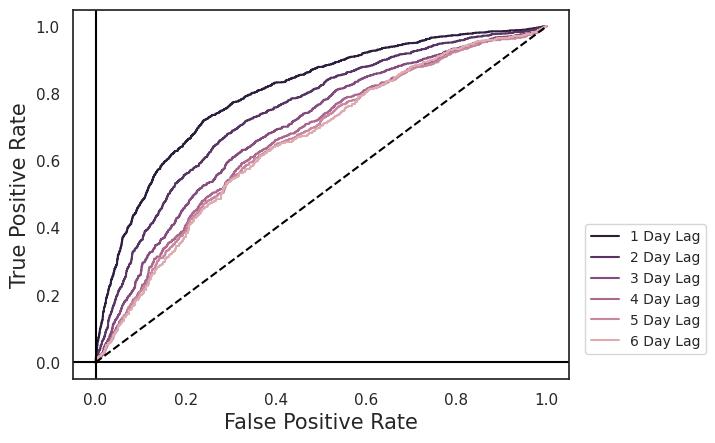

In [ ]:
fig, ax = plt.subplots()
ax.set_facecolor('white')

for color, fpr_tpr_tuple, i in zip(np.array(color_list_reduced)[-1:0:-1], fpr_tprs, range(1,8)):
    plt.plot(fpr_tpr_tuple[0], fpr_tpr_tuple[1], label='{0} Day Lag'.format(i), color=color)

plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.axhline(0, color='black')
plt.axvline(0, color='black')
legend = plt.legend(loc="lower right", prop={'size': 10}, bbox_to_anchor=(1.29, 0.05))
plt.savefig(ROOT+'figures/{0}_lagged_roc_curves_Fig_2.eps'.format(target), format='eps',
             dpi=300, facecolor='white', transparent=True, bbox_extra_artists=(legend,), bbox_inches='tight')

<ipython-input-30-8d81daee8518>:11: RuntimeWarning: Mean of empty slice
  heatmap(np.nanmean(activations,axis=0).T[arranged_indices],
<ipython-input-30-8d81daee8518>:27: RuntimeWarning: Mean of empty slice
  y_vector = np.nanmean(np.nanmean(activations,axis=0).squeeze(), axis=1)
<ipython-input-30-8d81daee8518>:30: RuntimeWarning: Mean of empty slice
  plot = sns.barplot(x=list(range(14)), y=np.nanmean(np.nanmean(activations,axis=0).squeeze(), axis=1),
<ipython-input-30-8d81daee8518>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot = sns.barplot(x=list(range(14)), y=np.nanmean(np.nanmean(activations,axis=0).squeeze(), axis=1),
<ipython-input-30-8d81daee8518>:30: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  plot = sns.barplot(x=list(range(14)), y=np.na

There is a -0.2556511340089628 % change between day 0 and 1


<ipython-input-30-8d81daee8518>:43: RuntimeWarning: Mean of empty slice
  y_vector = np.nanmax(np.nanmean(activations, axis=0).T[arranged_indices], axis=0)
<ipython-input-30-8d81daee8518>:45: RuntimeWarning: Mean of empty slice
  plot = sns.barplot(x=list(range(14)), y=np.nanmax(np.nanmean(activations, axis=0).T[arranged_indices], axis=0),
<ipython-input-30-8d81daee8518>:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot = sns.barplot(x=list(range(14)), y=np.nanmax(np.nanmean(activations, axis=0).T[arranged_indices], axis=0),
<ipython-input-30-8d81daee8518>:45: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  plot = sns.barplot(x=list(range(14)), y=np.nanmax(np.nanmean(activations, axis=0).T[arranged_indices], axis=0),
<ipython-input-30-8d81daee8518>:56: R

['hemocrit_max' 'potassium_med' 'atypical lymphocytes_min' 'smx-tmp'
 'amiodarone' 'furosemide' 'hemocrit_max' 'acetominophen' 'epoetin'
 'amiodarone' 'asprin' 'inr_std' 'warfarin' 'asprin']


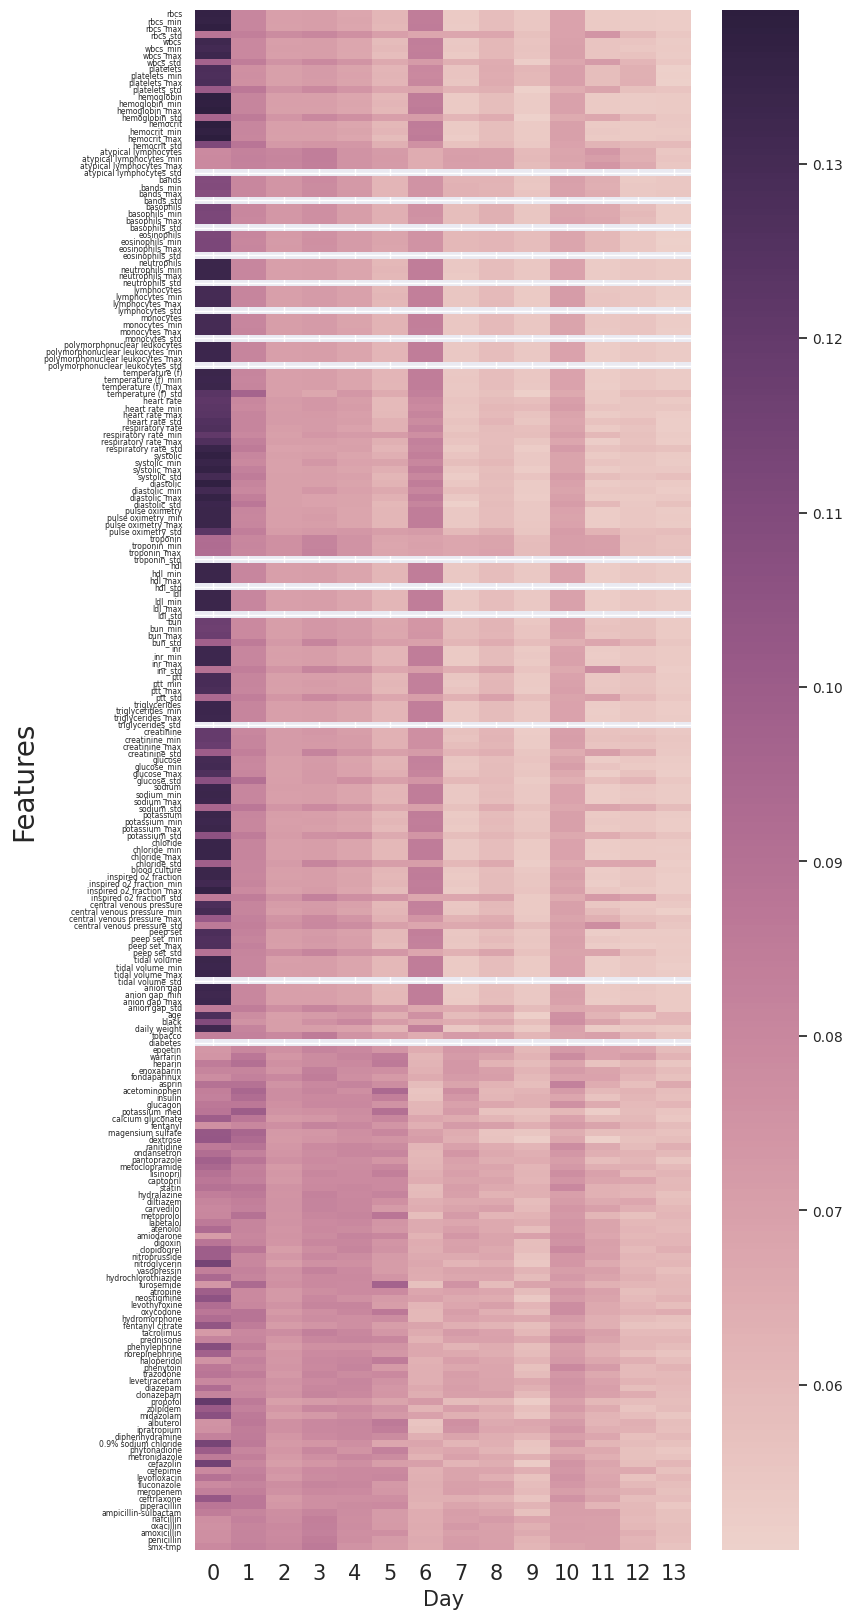

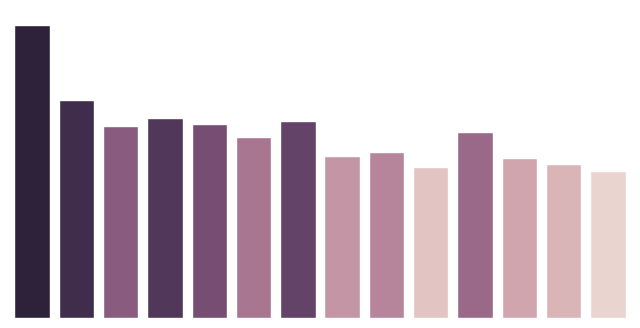

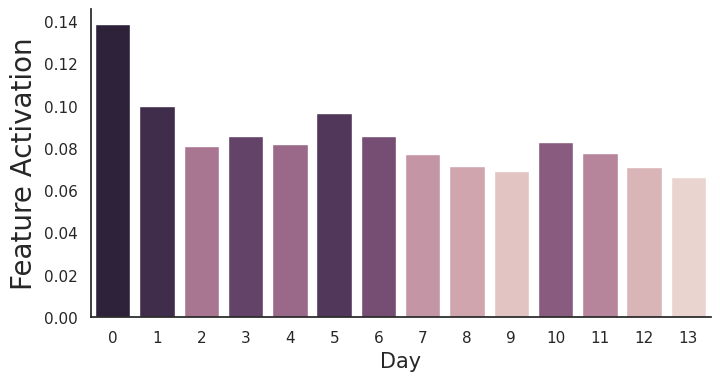

In [ ]:
##############
## FIGURE 3 ##
##############

## GET HEATMAPS FOR ALL INCIDENTS AVERAGE ##

plt.figure(figsize = (8,20))

sns.set(font_scale = 0.5)

heatmap(np.nanmean(activations,axis=0).T[arranged_indices],
        square=False,
        yticklabels=np.array(features)[arranged_indices],
        cmap=my_cmap)
plt.gcf().axes[-1].tick_params(labelsize=10)
plt.xticks(np.arange(TIME_STEPS)+0.5, np.arange(TIME_STEPS), fontsize=15) #, rotation=45,)
plt.xlabel('Day', fontsize=15)
plt.ylabel('Features', fontsize=20)
plt.savefig(ROOT+'figures/heatmap_{0}_med_ranked_average_activation_Figure_3.eps'.format(target),
            format='eps', dpi=300, bbox_inches='tight')

## MAKE THE BARPLOT THAT GOES ON TOP OF THE HEATMAP ##
## THE ATTENTION ON EVERY TIME STEP AVERAGED OVER FEATURES ##

plt.figure(figsize = (8,4))
sns.set(style="white")
y_vector = np.nanmean(np.nanmean(activations,axis=0).squeeze(), axis=1)
print('There is a {0} % change between day 0 and 1'.format((y_vector[1] - y_vector[0])/float(y_vector[0])))
color_rank = np.argsort(np.argsort(y_vector))
plot = sns.barplot(x=list(range(14)), y=np.nanmean(np.nanmean(activations,axis=0).squeeze(), axis=1),
                    palette=np.array(color_list)[color_rank])
plot.set(xticklabels=[])
plot.set(yticklabels=[])
sns.despine(left=True, bottom=True)

plt.savefig(ROOT+'figures/heatmap_{0}_med_ranked_average_barplot_Figure_3.eps'.format(target),
            format='eps', dpi=300, bbox_inches='tight')

## IDENTIFY MOST IMPORTANT FEATURE AT EVERY TIME STEP ##

plt.figure(figsize = (8,4))
sns.set(style="white")
y_vector = np.nanmax(np.nanmean(activations, axis=0).T[arranged_indices], axis=0)
color_rank = np.argsort(np.argsort(y_vector))
plot = sns.barplot(x=list(range(14)), y=np.nanmax(np.nanmean(activations, axis=0).T[arranged_indices], axis=0),
                    palette=np.array(color_list)[color_rank])
plt.xlabel('Day', fontsize=15)
plt.ylabel('Feature Activation', fontsize=20)
sns.despine()# left=True, bottom=True)

plt.savefig(ROOT+'figures/{0}_highest_feature_activation_by_timestep_barplot_Figure_3.eps'.format(target),
            format='eps', dpi=300, bbox_inches='tight')

## list of features by day that these activations correspond to ##

np.nanargmax(np.nanmean(activations, axis=0).T[arranged_indices], axis=0)
print(np.array(features)[arranged_indices][np.nanargmax(np.nanmean(activations, axis=0).T[arranged_indices],
                                                     axis=0)])
#####

In [ ]:
def find_intrahospital_incidents():
    IHI_keys =  np.where(np.nansum(Y_TEST.squeeze(), axis=1) > 1)[0]
    for i in IHI_keys:
        predictions = Y_PRED_mask_0[i][~y_boolmat_test[i].squeeze()].squeeze()
        ground_truth = Y_TEST[i].squeeze()[~y_boolmat_test[i].squeeze()].squeeze()
        acc = accuracy_score(np.around(predictions), ground_truth)
        criteria = (acc > .9 and
#                    np.around(predictions[0]) == 0 and
                    (np.add(ground_truth, np.around(predictions)) == 2).any()  and
                    (ground_truth[0] == 0) and
                    (np.sum(ground_truth[0:2]) == 0) and
#                    (np.sum(ground_truth) > 1) and
                    ground_truth.shape[0] == 14)
        if criteria:
            print("Person {0} with IHI".format(i))
            print('Ground Truth')
            print(ground_truth)
            print('Predicted Sequence')
            print(np.around(predictions))
            print('\n')

find_intrahospital_incidents()

Person 16 with IHI
Ground Truth
[0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Predicted Sequence
[0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


Person 45 with IHI
Ground Truth
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
Predicted Sequence
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]


Person 62 with IHI
Ground Truth
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
Predicted Sequence
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]


Person 127 with IHI
Ground Truth
[0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0.]
Predicted Sequence
[0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0.]


Person 216 with IHI
Ground Truth
[0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
Predicted Sequence
[0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]


Person 261 with IHI
Ground Truth
[0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0.]
Predicted Sequence
[0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0.]


Person 262 with IHI
Ground Truth
[0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Predicted Sequence
[0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0.]


Person 36

In [ ]:
if target == 'MI':
    patient_num = 3947
elif target == 'SEPSIS':
    patient_num = 927
elif target == 'VANCOMYCIN':
    patient_num = 582

In [ ]:
def patient_heatmap(patient_num, savefig=False, target=None):

        if target == None:
            raise Exception('Specify Target')

        print('\n')
        print('Visualize Inputs')
        print('Ground Truth')
        ground_truth = Y_TEST[patient_num].squeeze()[~y_boolmat_test[patient_num].squeeze()]
        print(ground_truth)
        print('Predicted Sequence')
        predictions = Y_PRED_mask_0[patient_num].squeeze()[~y_boolmat_test[patient_num].squeeze()]
        print(np.around(predictions))

        if target == 'MI':
            color_list_barplot = sns.color_palette("Reds", ground_truth.shape[0])
        elif target == 'SEPSIS':
            color_list_barplot = sns.cubehelix_palette(ground_truth.shape[0], start=2, rot=0, dark=0.25, light=.95)
        elif target == 'VANCOMYCIN':
            color_list_barplot = sns.cubehelix_palette(ground_truth.shape[0])

        print('Individual Heatmap')
        plt.figure(figsize = (8,20))
        sns.set(font_scale = 0.5)

    #    activations_map = np.nanmean(activations,axis=0)/(np.nanmax(np.nanmean(activations, axis=0), axis=1))[:,None]
        activations_map = activations[patient_num]/np.nanmax(activations[patient_num,::,::], axis=1)[:,None]
        heatmap(activations[patient_num].T[arranged_indices],
                       square=False,
#                      vmin=np.amin(activations[patient_num,:,:]),
#                      vmax=np.amax(activations[patient_num,:,:]),
                     yticklabels=np.array(features)[arranged_indices], cmap=my_cmap)
        plt.gcf().axes[-1].tick_params(labelsize=10)
        plt.xticks(np.arange(TIME_STEPS)+0.5, np.arange(TIME_STEPS), fontsize=15)
        plt.yticks(fontsize=8)
        plt.xlabel('Day', fontsize=20)
        plt.ylabel('Features', fontsize=20)
        plt.xticks(np.arange(TIME_STEPS)+0.5, np.arange(TIME_STEPS), fontsize=15) #, rotation=45,)

        if savefig:
            plt.savefig(ROOT+'figures/heatmap_{0}_patient_{1}.eps'.format(target, patient_num),
                        format='eps', dpi=300, bbox_inches='tight')

        rel_vector = np.nanmean(activations[patient_num,::,::].T.squeeze(), axis=0)
        rel_vector = rel_vector[~y_boolmat_test[patient_num].squeeze()]
        color_order = np.argsort(rel_vector, axis=0)
        color_order_order = np.argsort(color_order)

        plt.figure(figsize = (8,4))
        sns.set(style="white")
        plot = sns.barplot(x=np.arange(14)[~y_boolmat_test[patient_num].squeeze()], y=rel_vector,
                           palette=np.array(color_list_barplot)[color_order_order])
        plot.set(xticklabels=[])
        plot.set(yticklabels=[])
        sns.despine(left=True, bottom=True)

        print('Patient Features Heatmap')
        if savefig:
            plt.savefig(ROOT+'figures/barplot_for_heatmap_{0}_patient_{1}.eps'.format(target, patient_num),
                        format='eps', dpi=300, bbox_inches='tight')

        plt.figure(figsize= (8,20))
        sns.set(font_scale = 0.5)
        activations_map = X_TEST[patient_num,::,::]/np.nanmax(X_TEST[patient_num,::,::], axis=0) #[:,None]
        heatmap(X_TEST[patient_num,::,::].T[arranged_indices], square=False,
                yticklabels=np.array(features)[arranged_indices],
                cmap=my_cmap) #, cbar_kws={'ticks':[]})
        plt.gcf().axes[-1].tick_params(labelsize=10)
        plt.xticks(np.arange(TIME_STEPS)+0.5, np.arange(TIME_STEPS), fontsize=15) #, rotation=45,)
        plt.yticks(fontsize=8)
        plt.xlabel('Day', fontsize=20)
        plt.ylabel('Features', fontsize=20)
        plt.xticks(np.arange(TIME_STEPS)+0.5, np.arange(TIME_STEPS), fontsize=15) #, rotation=45,)
        if savefig:
            plt.savefig(ROOT+'figures/features_heatmap_{0}_patient_{1}.eps'.format(target, patient_num),
                        format='eps', dpi=300, bbox_inches='tight')

        rel_vector = np.nanmean(X_TEST[patient_num,::,::].T.squeeze(), axis=0)[~y_boolmat_test[patient_num].squeeze()]
        color_order = np.argsort(rel_vector, axis=0)
        color_order_order = np.argsort(color_order)

        plt.figure(figsize = (8,4))
        sns.set(style="white")
        plot = sns.barplot(x=np.arange(14)[~y_boolmat_test[patient_num].squeeze()], y=rel_vector,
                           palette=np.array(color_list_barplot)[color_order_order])
        plot.set(xticklabels=[])
        plot.set(yticklabels=[])
        sns.despine(left=True, bottom=True)
        if savefig:
            plt.savefig(ROOT+'figures/barplot_features_heatmap_{0}_patient_{1}.eps'.format(target, patient_num),
                        format='eps', dpi=300, bbox_inches='tight')

[0.37315536 0.9735452  0.37268364 0.21629629 0.2394474  0.58031386
 0.13078956 0.32413176 0.44089696 0.2237296  0.1723105  0.32874835
 0.3658621  0.15199372]
4.8939037


<ipython-input-38-5e1517b7b79a>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot = sns.barplot(x=days_string, y=y_vector[days],
<ipython-input-38-5e1517b7b79a>:25: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  plot = sns.barplot(x=days_string, y=y_vector[days],


['peep set_std' 'potassium_std' 'clopidogrel']
[0.58031386 0.13078956 0.32413176]


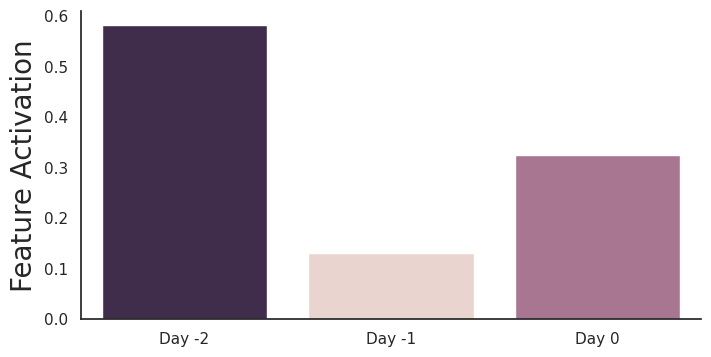

In [ ]:
## Get the top activations for that day, the day before, the day before ##

def features_driving_incident(patient_num, savefig=False):

    plt.figure(figsize = (8,4))
    sns.set(style="white")

    if np.where(Y_TEST[patient_num] == 1)[0][0] == 1:
        day_zero = 1
        day_neg_one = 0
        days = np.array([day_neg_one, day_zero])
        days_string = ['Day -1', 'Day 0']
    else:
        assert np.where(Y_TEST[patient_num] == 1)[0][0] >= 2
        day_zero = np.where(Y_TEST[patient_num] == 1)[0][0]
        day_neg_one = day_zero - 1
        day_neg_two = day_zero - 2
        days = np.array([day_neg_two, day_neg_one, day_zero])
        days_string = ['Day -2', 'Day -1', 'Day 0']

    y_vector = np.nanmax(activations[patient_num], axis=1) #[days]
    print(y_vector)
    print(np.nansum(y_vector))
    color_rank = np.argsort(np.argsort(y_vector))
    plot = sns.barplot(x=days_string, y=y_vector[days],
                       palette=np.array(color_list)[color_rank][days])
    plt.ylabel('Feature Activation', fontsize=20)
        #plot.set(xticklabels=[])
        #plot.set(yticklabels=[])
    sns.despine() # left=True, bottom=True)

    if savefig:
        plt.savefig(ROOT+'figures/max_activation_pre_incident_barplot_Figure_4_{0}_patient_{1}.eps'.format(target, patient_num),
             format='eps', dpi=300, bbox_inches='tight')

    ## list of features by day that these activations correspond to ##

    print(np.array(features)[np.nanargmax(activations[patient_num], axis=1)][days])
    print(np.nanmax(activations[patient_num], axis=1)[days])

#####

features_driving_incident(patient_num, savefig=True)

#####

In [ ]:
print(activations[patient_num].shape)

print(activations[patient_num].T[features.index('phenylephrine'),1])

#activations[patient_num][list(np.array(features)[arranged_indices]).index('levothyroxine'),0]

(14, 223)
0.08345596


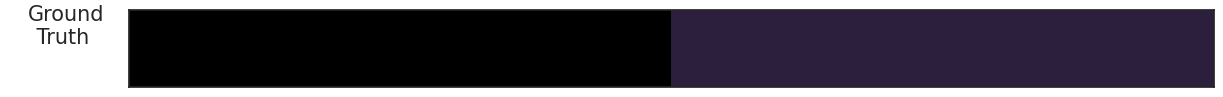

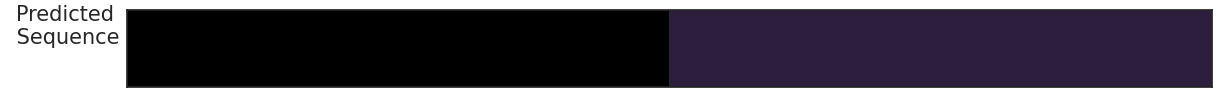

In [ ]:
## FIGURE 4 ##

def predictions_labels_palplot(patient_num, savefig=False):

    color_list_gt = np.array(color_list.copy())
    color_list_gt[Y_TEST[patient_num].squeeze() == 1] = color_list_gt[-1]
    color_list_gt[Y_TEST[patient_num].squeeze() == 0] = [0,0,0]
    sns.palplot(color_list_gt)
    plt.ylabel('Ground\n    Truth     ', fontsize=15, rotation='horizontal', labelpad=45) #.set_rotation(0)

    if savefig:
        plt.savefig(ROOT+'figures/{0}_GT_labels_Figure_4.eps'.format(target), format='eps',
                dpi=300, facecolor='white', transparent=True, bbox_extra_artists=(legend,), bbox_inches='tight')

    color_list_pred = np.array(color_list.copy())
    color_list_pred[np.around(Y_PRED_mask_0[patient_num].squeeze()) == 1] = color_list_pred[-1]
    color_list_pred[np.around(Y_PRED_mask_0[patient_num].squeeze()) == 0] = [0,0,0]
    sns.palplot(color_list_pred)
    plt.ylabel('Predicted\n Sequence', fontsize=15, rotation='horizontal', labelpad=45)
    if savefig:
        plt.savefig(ROOT+'figures/{0}_PRED_labels_Figure_4.eps'.format(target), format='eps',
                   dpi=300, facecolor='white', transparent=True, bbox_extra_artists=(legend,),
                    bbox_inches='tight')

predictions_labels_palplot(patient_num, savefig=True)

In [ ]:
# TODO use the get_activations function in combo with the graphs created to populate this section

# Results

**Masking Results:**

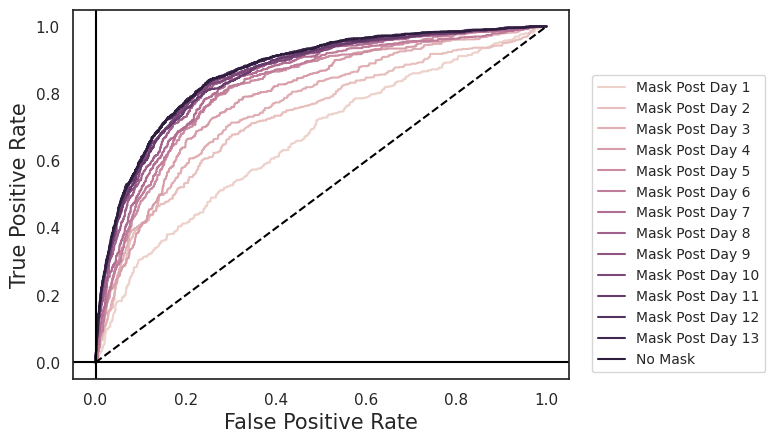
*   AUC Score without Masking (0.8654588972500161): The model performs the best when has access to all the information without any masking.

*   AUC Scores with Masking: When masking starts the data post certain days (meaning you hide the data from the model starting the day after the number indicated), the AUC scores change slightly but not drastically at first. Masking after day 13 yields an AUC of 0.8656182525244172, which is very close to the AUC without any masking.

*   Decreasing AUC with More Masking: As more data is masked out (moving from day 13 to day 1), the AUC scores tend to decrease with the lowest being the day 1 mask giving an AUC of 0.6588877174122771.

**Lag Prediction Results:**

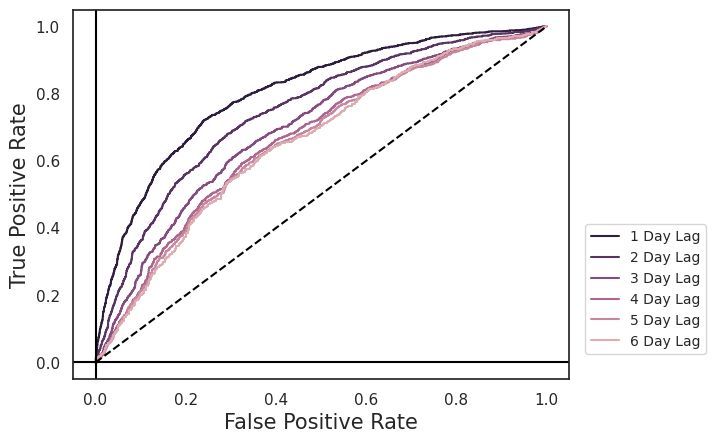
* PPV for full model w/ 1 day lag is 0.575019638648861
* Sensitivity for full model w/ 1 day lag is 0.50


```
                precision   recall   f1-score   support

         0.0       0.86      0.89      0.87      4799
         1.0       0.58      0.50      0.54      1454

    accuracy                           0.80      6253
   macro avg       0.72      0.70      0.70      6253
weighted avg       0.79      0.80      0.79      6253
```

As the lag increases from 1 day to 6 days, the models performance generally decreases.

**Activation Weights:**

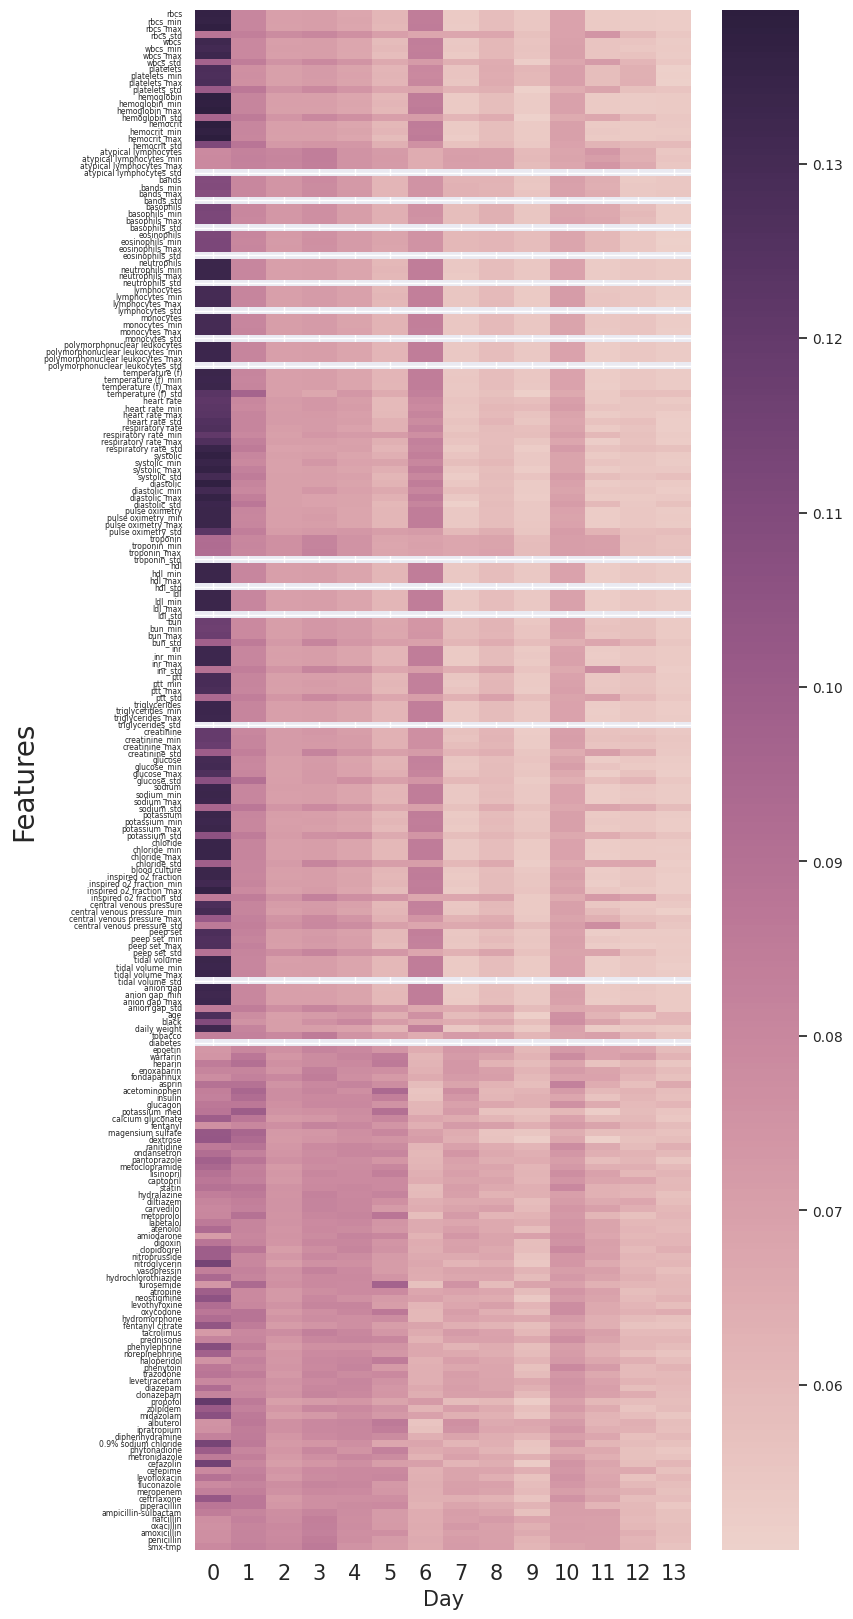
*   Feature-by-feature Activation: Heatmap shows the average activation value for each feature across different days. The darker colors indicate high activation values meaning they are considered more important. Noteable features such as hemocrit_max and potassium_med are shown at the beginning and towards the end of the 14-day period.

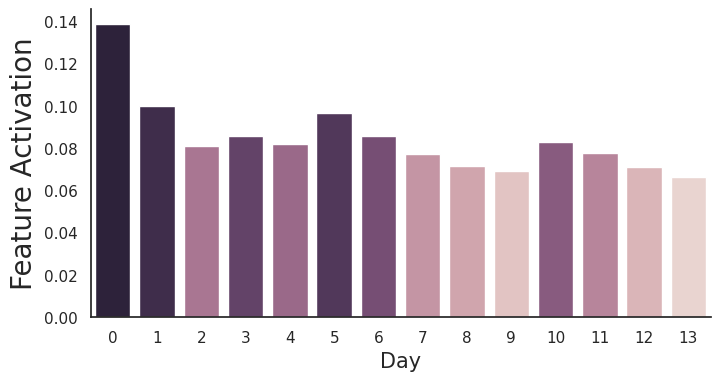
*   Activation for each Day: The barplot shows the average activation where darker colors indicate higher activation and lighter colors indicate lower activation over all features for each day. There is a trend of decreasing feature activation over the 14 days.

**Activation Weights of Subsequent Days:**

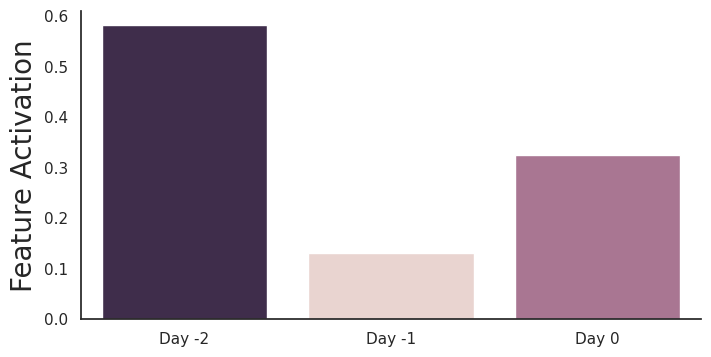

The bar heights represent the magnitude of the feature activations, with "Day -2" showing the highest activation (0.58031386), followed by a significant drop on "Day -1" (0.13078956) and a partial rebound on "Day 0" (0.32413176).


# Discussion & Analyses

In this section, we discuss our work and future plans.

**Make assessment that the paper is reproducible or not**


After spending some time with the linked code, we can make the assesment that the paper is reproducible. Despite some inital hurdles related to the programming environments, the actual execution of the code required very minimal changes (imports). The same MIMIC-III dataset was used and the MIMIC parser was able to parse and transform the data into what was needed to run the model. The use of Keras, Tensorflow, Pandas and other commonly used frameworks eased the ability for us to reproduce the results with the given code. Based on what we have been able to reproduce so far with a trimmed dataet, it does seem that the the hypothesis are still acheievable.


**Describe “What was easy” and “What was difficult” during the reproduction**

What was "easy"?

- Once the environment is set up correctly, the provided code runs without much modification
- The code is broken down into useful functions and classes that help interpretability
- Once the data was mounted in google drive correctly, there were no concerns with pre-processed file sizes


What was "hard"?

- The amount of data needed makes it hard to run from a local environment
- The amount of data also can lead to occacsional run time issues, and memory issues
- The environment set up was difficult as it required a lot of trial and error to find the correct set of imports and system calls.
- Unable to train on the full pre-processed data in google collab notebook (had to trim down to first 50k)

**Make suggestions to the author or other reproducers on how to improve the reproducibility.**


- One thing that can be improved is to update the dependencies used. Some of the packages from keras have been updated so the code is slightly out of date for that.
- One improvement we made to the code was to chunk the input as it is read. This allows the pre-processing tasks to run without timing or failing on most platforms.
- The code comments are useful, but a little more documentation would help reproducibility

**What will you do in next phase**

In the next phase we plan to do some further analysis on the mechanisms used. At this current checkpoint in the project there is still ambiguitiy of how different parameters in the model led to the desired outcome. By spending more time analyzing and performing abalations, we would be able to understand the impacts of certain parameters more thoroughly

Specifically these are our goals for the next submission:

- Run abalations to improve understanding of the parameters
- Perform model comparisions between the 3 key targets.
- Improve evaluation criteria based on the results of the experiments
- Perform analysis on the models' hyperparameters


# References

1.   Kaji, Deepak A et al. “An attention based deep learning model of clinical events in the intensive care unit.”, PLoS ONE 14 (2019): n. pag., doi: https://doi.org/10.1371/journal.pone.0211057

